In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import Optional, Union, List
from sklearn.metrics.pairwise import cosine_similarity
from pykalman import KalmanFilter
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import copy
import scipy
from git_code.Chapter3.KalmanFilters import KalmanFilters
from git_code.Chapter3.OutlierDetection import DistanceBasedOutlierDetection
from git_code.Chapter3.DataTransformation import LowPassFilter, PrincipalComponentAnalysis

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [2]:
import os
import sys
from pathlib import Path

# Get the current working directory
current_working_directory = os.getcwd()
print("Current working directory:", current_working_directory)

Current working directory: /Users/aledpro/Desktop/VUa/First_Year/P6


# Read Data

Trial 1

In [3]:
yaoyi_trial_1_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/yaoyi_trial_1_audio_spec.csv')
yaoyi_trial_1_brightness_raw = pd.read_csv('./data/Brightness/yaoyi_trial_1_brightness.csv')
yaoyi_trial_1_audio_amp_raw = pd.read_csv('./data/Audio_Amp/yaoyi_trial_1_audio_amp.csv')
yaoyi_trial_1_acceleration_raw = pd.read_csv('./data/Acceleration/yaoyi_trial_1_acceleration.csv')
yaoyi_trial_1_inclination_raw = pd.read_csv('./data/Inclination/yaoyi_trial_1_inclination.csv')
yaoyi_trial_1_audio_spectrum_raw 

Time (s)  Peak-Frequency
0        0.255078         46.8750
1        0.297745         70.3125
2        0.463538         70.3125
3        0.613441         70.3125
4        0.656107         70.3125
...           ...             ...
21070  909.061287         46.8750
21071  909.103954         46.8750
21072  909.146620         46.8750
21073  909.189287         46.8750
21074  909.231954         46.8750

[21075 rows x 2 columns]

In [4]:
yaoyi_trial_1_brightness_raw

timestamp  BrightnessEV
0      1717743150995      2.873449
1      1717743151057      2.866906
2      1717743151123      2.806646
3      1717743151190      2.847098
4      1717743151257      2.912095
...              ...           ...
13654  1717744061255      3.064837
13655  1717744061321      3.041250
13656  1717744061388      3.025309
13657  1717744061455      3.033302
13658  1717744061521      3.049156

[13659 rows x 2 columns]

In [5]:
kiara_trial_1_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/kiara_trial_1_audio_spec.csv')
kiara_trial_1_brightness_1 = pd.read_csv('./data/Brightness/kiara_trial_1_brightness_1.csv')
kiara_trial_1_brightness_2 = pd.read_csv('./data/Brightness/kiara_trial_1_brightness_2.csv')
kiara_trial_1_brightness_raw = pd.concat([kiara_trial_1_brightness_1, kiara_trial_1_brightness_2])
kiara_trial_1_brightness_raw.reset_index(drop=True, inplace=True)
kiara_trial_1_brightness_raw.to_csv('./data/Brightness/kiara_trial_1_brigtness.csv', index=True)
kiara_trial_1_audio_amp_raw = pd.read_csv('./data/Audio_Amp/kiara_trial_1_audio_amp.csv')
kiara_trial_1_acceleration_raw = pd.read_csv('./data/Acceleration/kiara_trial_1_acceleration.csv')
kiara_trial_1_inclination_raw = pd.read_csv('./data/Inclination/kiara_trial_1_inclination.csv')

In [6]:
kiara_trial_1_brightness_raw

timestamp  BrightnessEV
0      1717741592172      5.741496
1      1717741592197      5.741496
2      1717741592264      5.753519
3      1717741592331      5.759492
4      1717741592397      5.747520
...              ...           ...
16093  1717742870648      6.057717
16094  1717742870715      6.050022
16095  1717742870784      6.050022
16096  1717742870847      6.050022
16097  1717742870914      6.050022

[16098 rows x 2 columns]

In [7]:
esmee_trial_1_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/esmee_trial_1_audio_spec.csv')
esmee_trial_1_brightness_1 = pd.read_csv('./data/Brightness/esmee_trial_1_brightness_1.csv')
esmee_trial_1_brightness_2 = pd.read_csv('./data/Brightness/esmee_trial_1_brightness_2.csv')
esmee_trial_1_brightness_3 = pd.read_csv('./data/Brightness/esmee_trial_1_brightness_3.csv')
esmee_trial_1_brightness_raw = pd.concat([esmee_trial_1_brightness_1, esmee_trial_1_brightness_2, esmee_trial_1_brightness_3])
esmee_trial_1_brightness_raw.reset_index(drop=True, inplace=True)
esmee_trial_1_brightness_raw.to_csv('./data/Brightness/esmee_trial_1_brightness.csv', index=True)
esmee_trial_1_audio_amp_raw = pd.read_csv('./data/Audio_Amp/esmee_trial_1_audio_amp.csv')
esmee_trial_1_acceleration_raw = pd.read_csv('./data/Acceleration/esmee_trial_1_acceleration.csv')
esmee_trial_1_inclination_raw = pd.read_csv('./data/Inclination/esmee_trial_1_inclination.csv')

In [8]:
esmee_trial_1_brightness_raw

timestamp  BrightnessEV
0      1717739946496      2.606777
1      1717739946551      2.614682
2      1717739946617      2.614682
3      1717739946685      2.598828
4      1717739946751      2.590836
...              ...           ...
14065  1717741076270      3.494719
14066  1717741076341      3.673567
14067  1717741076404      3.815181
14068  1717741076470      3.916372
14069  1717741076536      3.968366

[14070 rows x 2 columns]

In [9]:
def convert_timestamps_to_seconds(df, timestamp_column):
    
    df[timestamp_column] = (df[timestamp_column] - df[timestamp_column].min()) / 1000.0
    
    return df

In [10]:
yaoyi_trial_1_brightness = yaoyi_trial_1_brightness_raw.copy(deep=True)
yaoyi_trial_1_brightness = convert_timestamps_to_seconds(yaoyi_trial_1_brightness, 'timestamp')
kiara_trial_1_brightness = kiara_trial_1_brightness_raw.copy(deep=True)
kiara_trial_1_brightness = convert_timestamps_to_seconds(kiara_trial_1_brightness, 'timestamp')
esmee_trial_1_brightness = esmee_trial_1_brightness_raw.copy(deep=True)
esmee_trial_1_brightness = convert_timestamps_to_seconds(esmee_trial_1_brightness, 'timestamp')

Trial 2

In [11]:
yaoyi_trial_2_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/yaoyi_trial_2_audio_spec.csv')
yaoyi_trial_2_brightness_raw = pd.read_csv('./data/Brightness/yaoyi_trial_2_brightness.csv')
yaoyi_trial_2_audio_amp_raw = pd.read_csv('./data/Audio_Amp/yaoyi_trial_2_audio_amp.csv')
yaoyi_trial_2_acceleration_raw = pd.read_csv('./data/Acceleration/yaoyi_trial_2_acceleration.csv')
yaoyi_trial_2_inclination_raw = pd.read_csv('./data/Inclination/yaoyi_trial_2_inclination.csv')

In [12]:
kiara_trial_2_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/kiara_trial_2_audio_spec.csv')
kiara_trial_2_brightness_1 = pd.read_csv('./data/Brightness/kiara_trial_2_brightness_1.csv')
kiara_trial_2_brightness_2 = pd.read_csv('./data/Brightness/kiara_trial_2_brightness_2.csv')
kiara_trial_2_brightness_raw = pd.concat([kiara_trial_2_brightness_1, kiara_trial_2_brightness_2])
kiara_trial_2_brightness_raw.reset_index(drop=True, inplace=True)
kiara_trial_2_brightness_raw.to_csv('./data/Brightness/kiara_trial_2_brigtness.csv', index=True)
kiara_trial_2_audio_amp_raw = pd.read_csv('./data/Audio_Amp/kiara_trial_2_audio_amp.csv')
kiara_trial_2_acceleration_raw = pd.read_csv('./data/Acceleration/kiara_trial_2_acceleration.csv')
kiara_trial_2_inclination_raw = pd.read_csv('./data/Inclination/kiara_trial_2_inclination.csv')

In [13]:
esmee_trial_2_audio_spectrum_raw = pd.read_csv('./data/Audio_Spectrum/esmee_trial_2_audio_spec.csv')
esmee_trial_2_brightness_raw = pd.read_csv('./data/Brightness/esmee_trial_2_brightness.csv')
esmee_trial_2_audio_amp_raw = pd.read_csv('./data/Audio_Amp/esmee_trial_2_audio_amp.csv')
esmee_trial_2_acceleration_raw = pd.read_csv('./data/Acceleration/esmee_trial_2_acceleration.csv')
esmee_trial_2_inclination_raw = pd.read_csv('./data/Inclination/esmee_trial_2_inclination.csv')

In [14]:
yaoyi_trial_2_brightness = yaoyi_trial_2_brightness_raw.copy(deep=True)
yaoyi_trial_2_brightness = convert_timestamps_to_seconds(yaoyi_trial_2_brightness, 'timestamp')

In [15]:
kiara_trial_2_brightness = kiara_trial_2_brightness_raw.copy(deep=True)
kiara_trial_2_brightness = convert_timestamps_to_seconds(kiara_trial_2_brightness, 'timestamp')

In [16]:
esmee_trial_2_brightness = esmee_trial_2_brightness_raw.copy(deep=True)
esmee_trial_2_brightness = convert_timestamps_to_seconds(esmee_trial_2_brightness, 'timestamp')

# **Aggragate for 1s** 

In [17]:
def aggregate_data_multiple_columns(df, timestamp_column, interval, features, trial_num, experimenter):

    df_copy = df.copy()

    df_copy['interval_group'] = (df_copy[timestamp_column] // interval) * interval
    
    aggregation_functions = {col: ['max', 'min', 'median', 'mean', 'std'] for col in features}
    
    aggregated = df_copy.groupby('interval_group').agg(aggregation_functions)
    
    aggregated.columns = ['_'.join(col).strip() for col in aggregated.columns.values]
    
    aggregated.reset_index(inplace=True)
    
    aggregated.rename(columns={'interval_group': 'timestamp'}, inplace=True)
    
    max_time = df[timestamp_column].max()
    last_group = (max_time // interval) * interval
    if max_time > last_group:
        last_group_data = df_copy[df_copy[timestamp_column] > last_group]
        if not last_group_data.empty:
            last_group_stats = last_group_data[features].agg(aggregation_functions).T
            new_columns = {}
            for index, row in last_group_stats.iterrows():
                variable_name = index
                for col in last_group_stats.columns:
                    new_columns[col] = f"{variable_name}_{col}"  # Construct new column name
            last_group_stats.rename(columns=new_columns, inplace=True)
            last_group_stats.drop_duplicates(inplace=True)
            last_group_stats['timestamp'] = max_time
            aggregated = pd.merge(aggregated, last_group_stats, how='outer')
            aggregated['trial'] = trial_num
            aggregated['experimenter'] = experimenter
            
    return aggregated

In [18]:
yaoyi_trial_1_brightness_agg = aggregate_data_multiple_columns(yaoyi_trial_1_brightness, 'timestamp', 1, ['BrightnessEV'], '1', 'Yaoyi')
yaoyi_trial_2_brightness_agg = aggregate_data_multiple_columns(yaoyi_trial_2_brightness, 'timestamp', 1, ['BrightnessEV'], '2', 'Yaoyi')
yaoyi_trial_2_brightness_agg

timestamp  BrightnessEV_max  BrightnessEV_min  BrightnessEV_median  \
0        0.000          1.911855          1.288233             1.443913   
1        1.000          1.870827          1.557137             1.633269   
2        2.000          1.816614          1.476764             1.592241   
3        3.000          1.780545          1.499132             1.571282   
4        4.000          2.184385          1.786619             1.840169   
..         ...               ...               ...                  ...   
713    713.000          3.316994          3.233336             3.254710   
714    714.000          4.072522          3.330477             3.762476   
715    715.000          4.226719          3.451432             4.071113   
716    716.000          3.364396          3.346145             3.353096   
717    716.392          3.364396          3.346145             3.353096   

     BrightnessEV_mean  BrightnessEV_std trial experimenter  
0             1.518760          0.240927     2        Yaoyi  
1             1.654649          0.085028     2        Yaoyi  
2             1.601364          0.093029     2        Yaoyi  
3             1.617590          0.116108     2        Yaoyi  
4             1.903222          0.139069     2        Yaoyi  
..                 ...               ...   ...          ...  
713           3.272730          0.027808     2        Yaoyi  
714           3.730140          0.230926     2        Yaoyi  
715           3.967858          0.252422     2        Yaoyi  
716           3.353767          0.007031     2        Yaoyi  
717           3.353767          0.007031     2        Yaoyi  

[718 rows x 8 columns]

In [19]:
yaoyi_trial_1_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Yaoyi')
yaoyi_trial_2_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Yaoyi')

In [20]:
yaoyi_trial_1_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Yaoyi')
yaoyi_trial_2_audio_amp_agg = aggregate_data_multiple_columns(yaoyi_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Yaoyi')

In [21]:
yaoyi_trial_2_audio_amp_agg

timestamp  Sound pressure level (dB)_max  Sound pressure level (dB)_min  \
0      0.000000                      -4.800901                     -24.889771   
1      1.000000                      -8.623928                     -17.028175   
2      2.000000                     -10.295810                     -16.871763   
3      3.000000                     -13.216578                     -16.491051   
4      4.000000                     -12.562503                     -16.111604   
..          ...                            ...                            ...   
715  715.000000                     -13.762768                     -20.846932   
716  716.000000                     -12.057986                     -15.807089   
717  717.000000                      -7.227903                     -15.222865   
718  718.000000                      -9.314695                     -14.830136   
719  718.470128                      -9.314695                     -14.830136   

     Sound pressure level (dB)_median  Sound pressure level (dB)_mean  \
0                          -16.416692                      -15.961950   
1                          -13.815021                      -13.087071   
2                          -15.156037                      -14.356600   
3                          -14.407502                      -14.614102   
4                          -14.772753                      -14.721363   
..                                ...                             ...   
715                        -18.375733                      -18.366615   
716                        -14.627188                      -14.242499   
717                        -11.240874                      -11.249674   
718                        -11.902692                      -12.496257   
719                        -11.902692                      -12.496257   

     Sound pressure level (dB)_std trial experimenter  
0                         5.801519     2        Yaoyi  
1                         3.220480     2        Yaoyi  
2                         2.211416     2        Yaoyi  
3                         1.092908     2        Yaoyi  
4                         1.120848     2        Yaoyi  
..                             ...   ...          ...  
715                       2.299273     2        Yaoyi  
716                       1.315506     2        Yaoyi  
717                       2.689500     2        Yaoyi  
718                       2.283174     2        Yaoyi  
719                       2.283174     2        Yaoyi  

[720 rows x 8 columns]

In [22]:
yaoyi_trial_1_acceleration_agg = aggregate_data_multiple_columns(yaoyi_trial_1_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '1', 'Yaoyi')
# yaoyi_trial_1_acceleration_agg = yaoyi_trial_1_acceleration_agg.iloc[:-3]
yaoyi_trial_2_acceleration_agg = aggregate_data_multiple_columns(yaoyi_trial_2_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '2', 'Yaoyi')
# yaoyi_trial_2_acceleration_agg = yaoyi_trial_2_acceleration_agg.iloc[:-3]

In [23]:
yaoyi_trial_1_audio_spectrum_agg = aggregate_data_multiple_columns(yaoyi_trial_1_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '1', 'Yaoyi')
yaoyi_trial_2_audio_spectrum_agg = aggregate_data_multiple_columns(yaoyi_trial_2_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '2', 'Yaoyi')

In [24]:
yaoyi_trial_1_inclination_agg = aggregate_data_multiple_columns(yaoyi_trial_1_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '1', 'Yaoyi')
yaoyi_trial_2_inclination_agg = aggregate_data_multiple_columns(yaoyi_trial_2_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '2', 'Yaoyi')

In [25]:
def correct_sequence(df, column):

    values = df[column].tolist()
    expected_value = values[0]
    
    for i in range(1, len(values)):
        expected_value += 1
        if values[i] != expected_value:
            values[i] = expected_value

    if len(values) > 1 and values[-1] - values[-2] != 1:
        values[-1] = df[column].iloc[-1]
    
    df[column] = values

In [26]:
kiara_trial_1_brightness_agg = aggregate_data_multiple_columns(kiara_trial_1_brightness, 'timestamp', 1, ['BrightnessEV'], '1', 'Kiara')
correct_sequence(kiara_trial_1_brightness_agg, 'timestamp')
# kiara_trial_1_brigtness_agg = kiara_trial_1_brightness_agg.iloc[:-2]
kiara_trial_2_brightness_agg = aggregate_data_multiple_columns(kiara_trial_2_brightness, 'timestamp', 1, ['BrightnessEV'], '2', 'Kiara')
# kiara_trial_2_brigtness_agg = kiara_trial_1_brightness_agg.iloc[:-9]

In [27]:
kiara_trial_1_brightness

timestamp  BrightnessEV
0          0.000      5.741496
1          0.025      5.741496
2          0.092      5.753519
3          0.159      5.759492
4          0.225      5.747520
...          ...           ...
16093   1278.476      6.057717
16094   1278.543      6.050022
16095   1278.612      6.050022
16096   1278.675      6.050022
16097   1278.742      6.050022

[16098 rows x 2 columns]

In [28]:
kiara_trial_1_audio_spectrum_agg = aggregate_data_multiple_columns(kiara_trial_1_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '1', 'Kiara')
# kiara_trial_1_audio_spectrum_agg = kiara_trial_1_audio_spectrum_agg.iloc[:-1]
kiara_trial_2_audio_spectrum_agg = aggregate_data_multiple_columns(kiara_trial_2_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '2', 'Kiara')
kiara_trial_2_audio_spectrum_agg

timestamp  Peak-Frequency_max  Peak-Frequency_min  \
0      0.000000             70.3125              46.875   
1      1.000000             46.8750              46.875   
2      2.000000            164.0625              46.875   
3      3.000000             70.3125              46.875   
4      4.000000             46.8750              46.875   
..          ...                 ...                 ...   
608  608.000000            164.0625              46.875   
609  609.000000            164.0625              46.875   
610  610.000000            164.0625              46.875   
611  611.000000             46.8750              46.875   
612  611.025506             46.8750              46.875   

     Peak-Frequency_median  Peak-Frequency_mean  Peak-Frequency_std trial  \
0                 46.87500            49.804688            8.005430     2   
1                 46.87500            46.875000            0.000000     2   
2                 70.31250            80.502717           46.782270     2   
3                 46.87500            49.932065            8.070708     2   
4                 46.87500            46.875000            0.000000     2   
..                     ...                  ...                 ...   ...   
608              164.06250           118.206522           53.107468     2   
609              164.06250           126.358696           52.758816     2   
610              105.46875           109.375000           52.483742     2   
611               46.87500            46.875000                 NaN     2   
612               46.87500            46.875000                 NaN     2   

    experimenter  
0          Kiara  
1          Kiara  
2          Kiara  
3          Kiara  
4          Kiara  
..           ...  
608        Kiara  
609        Kiara  
610        Kiara  
611        Kiara  
612        Kiara  

[613 rows x 8 columns]

In [29]:
kiara_trial_1_audio_amp_agg = aggregate_data_multiple_columns(kiara_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Kiara')
kiara_trial_2_audio_amp_agg = aggregate_data_multiple_columns(kiara_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Kiara')

In [30]:
kiara_trial_1_acceleration_agg = aggregate_data_multiple_columns(kiara_trial_1_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '1', 'Kiara')
kiara_trial_1_acceleration_agg = kiara_trial_1_acceleration_agg.iloc[:-3]
kiara_trial_2_acceleration_agg = aggregate_data_multiple_columns(kiara_trial_2_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '2', 'Kiara')
kiara_trial_2_acceleration_agg = kiara_trial_2_acceleration_agg.iloc[:-3]

In [31]:
kiara_trial_1_acceleration_agg

timestamp  Linear Acceleration x (m/s^2)_max  \
0        0.000000                           0.304890   
1        1.000000                           0.230634   
2        2.000000                           0.683960   
3        3.000000                           0.112060   
4        4.000000                           0.460656   
...           ...                                ...   
1069  1069.000000                           0.084875   
1070  1070.000000                           0.109645   
1071  1071.000000                           0.168884   
1072  1072.000000                           0.100241   
1073  1072.072392                                NaN   

      Linear Acceleration x (m/s^2)_min  Linear Acceleration x (m/s^2)_median  \
0                             -0.397519                             -0.050728   
1                             -0.630368                             -0.097114   
2                             -0.445841                              0.023292   
3                             -0.402406                             -0.050409   
4                             -0.798082                              0.044026   
...                                 ...                                   ...   
1069                          -0.346860                             -0.026107   
1070                          -0.133530                             -0.002028   
1071                          -0.155156                             -0.040589   
1072                          -0.057954                              0.024437   
1073                                NaN                                   NaN   

      Linear Acceleration x (m/s^2)_mean  Linear Acceleration x (m/s^2)_std  \
0                              -0.058900                           0.122496   
1                              -0.093954                           0.177388   
2                               0.020294                           0.272748   
3                              -0.078404                           0.124374   
4                              -0.011428                           0.257938   
...                                  ...                                ...   
1069                           -0.051634                           0.092228   
1070                           -0.011437                           0.063225   
1071                           -0.021603                           0.079437   
1072                            0.032855                           0.053407   
1073                                 NaN                                NaN   

      Linear Acceleration y (m/s^2)_max  Linear Acceleration y (m/s^2)_min  \
0                              0.005907                          -0.390533   
1                              0.099924                          -0.688262   
2                              0.597810                          -1.206123   
3                              0.253684                          -0.533109   
4                              0.590465                          -0.751517   
...                                 ...                                ...   
1069                          -0.336250                          -1.109461   
1070                          -0.414399                          -0.610422   
1071                          -0.269274                          -0.619673   
1072                          -0.338814                          -0.456424   
1073                                NaN                                NaN   

      Linear Acceleration y (m/s^2)_median  \
0                                -0.216014   
1                                -0.182620   
2                                -0.185127   
3                                -0.130360   
4                                -0.209452   
...                                    ...   
1069                             -0.576485   
1070                             -0.531349   
1071                             -0.455079   
1072            

In [32]:
kiara_trial_1_inclination_agg = aggregate_data_multiple_columns(kiara_trial_1_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '1', 'Kiara')
kiara_trial_2_inclination_agg = aggregate_data_multiple_columns(kiara_trial_2_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '2', 'Kiara')

In [33]:
esmee_trial_1_brightness_agg = aggregate_data_multiple_columns(esmee_trial_1_brightness, 'timestamp', 1, ['BrightnessEV'], '1', 'Esmee')
correct_sequence(esmee_trial_1_brightness_agg, 'timestamp')
# esmee_trial_1_brightness_agg = esmee_trial_1_brightness_agg.iloc[:-2]
esmee_trial_2_brightness_agg = aggregate_data_multiple_columns(esmee_trial_2_brightness, 'timestamp', 1, ['BrightnessEV'], '2', 'Esmee')

In [34]:
esmee_trial_1_audio_spectrum_agg = aggregate_data_multiple_columns(esmee_trial_1_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '1', 'Esmee')
# esmee_trial_1_audio_spectrum_agg = esmee_trial_1_audio_spectrum_agg.iloc[:-1]
esmee_trial_2_audio_spectrum_agg = aggregate_data_multiple_columns(esmee_trial_2_audio_spectrum_raw, 'Time (s)', 1, ['Peak-Frequency'], '2', 'Esmee')

In [35]:
esmee_trial_1_audio_amp_agg = aggregate_data_multiple_columns(esmee_trial_1_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '1', 'Esmee')
esmee_trial_2_audio_amp_agg = aggregate_data_multiple_columns(esmee_trial_2_audio_amp_raw, 'Time (s)', 1, ['Sound pressure level (dB)'], '2', 'Esmee')

In [36]:
esmee_trial_1_acceleration_agg = aggregate_data_multiple_columns(esmee_trial_1_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '1', 'Esmee')
esmee_trial_1_acceleration_agg = esmee_trial_1_acceleration_agg.iloc[:-3]
esmee_trial_2_acceleration_agg = aggregate_data_multiple_columns(esmee_trial_2_acceleration_raw, 'Time (s)', 1, ['Linear Acceleration x (m/s^2)', 'Linear Acceleration y (m/s^2)', 'Linear Acceleration z (m/s^2)', 'Absolute acceleration (m/s^2)'], '2', 'Esmee')
esmee_trial_2_acceleration_agg = esmee_trial_2_acceleration_agg.iloc[:-3]

In [37]:
esmee_trial_1_inclination_agg = aggregate_data_multiple_columns(esmee_trial_1_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '1', 'Esmee')
esmee_trial_2_inclination_agg = aggregate_data_multiple_columns(esmee_trial_2_inclination_raw, 't (s)', 1, ['Inclination (deg)', 'Rotation (deg)'], '2', 'Esmee')

In [38]:
def merge_pd_horizontally(pd_list, key_cols=['timestamp', 'trial', 'experimenter']):
    
    pd_list_copy = [df.copy() for df in pd_list]
    max_timestamp_col = max(pd_list_copy, key=lambda df: df['timestamp'].max())['timestamp']

    for df in pd_list_copy:
        if df['timestamp'] is not max_timestamp_col:
            df.drop(columns=['timestamp'], inplace=True)

    merged_df = pd.concat(pd_list_copy, axis=1, join='outer')
    merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
    merged_df[['trial', 'experimenter']] = merged_df[['trial', 'experimenter']].ffill()

    return merged_df

In [39]:
yaoyi_trial_1_merged = merge_pd_horizontally([yaoyi_trial_1_brightness_agg, yaoyi_trial_1_audio_spectrum_agg, yaoyi_trial_1_audio_amp_agg, yaoyi_trial_1_acceleration_agg, yaoyi_trial_1_inclination_agg])

In [40]:
kiara_trial_1_merged = merge_pd_horizontally([kiara_trial_1_brightness_agg, kiara_trial_1_audio_spectrum_agg, kiara_trial_1_audio_amp_agg, kiara_trial_1_acceleration_agg, kiara_trial_1_inclination_agg])

In [41]:
esmee_trial_1_merged = merge_pd_horizontally([esmee_trial_1_brightness_agg, esmee_trial_1_audio_spectrum_agg, esmee_trial_1_audio_amp_agg, esmee_trial_1_acceleration_agg, esmee_trial_1_inclination_agg])

In [42]:
kiara_trial_2_merged = merge_pd_horizontally([kiara_trial_2_brightness_agg, kiara_trial_2_audio_spectrum_agg, kiara_trial_2_audio_amp_agg, kiara_trial_2_acceleration_agg, kiara_trial_2_inclination_agg])

In [43]:
yaoyi_trial_2_merged = merge_pd_horizontally([yaoyi_trial_2_brightness_agg, yaoyi_trial_2_audio_spectrum_agg, yaoyi_trial_2_audio_amp_agg ,yaoyi_trial_2_acceleration_agg, yaoyi_trial_2_inclination_agg])

In [44]:
esmee_trial_2_merged = merge_pd_horizontally([esmee_trial_2_brightness_agg, esmee_trial_2_audio_spectrum_agg, esmee_trial_2_audio_amp_agg, esmee_trial_2_acceleration_agg, esmee_trial_2_inclination_agg])

In [45]:
# Read and Merge Heart Rate

In [46]:
# suffixes_to_drop = ['_max', '_min', '_std', '_median']
# columns_to_drop = [col for col in yaoyi_trial_1_merged.columns if any(col.endswith(suffix) for suffix in suffixes_to_drop)]
# yaoyi_trial_1_merged.drop(columns=columns_to_drop, inplace=True)
# kiara_trial_1_merged.drop(columns=columns_to_drop, inplace=True)
# esmee_trial_1_merged.drop(columns=columns_to_drop, inplace=True)
# yaoyi_trial_2_merged.drop(columns=columns_to_drop, inplace=True)
# kiara_trial_2_merged.drop(columns=columns_to_drop, inplace=True)
# esmee_trial_2_merged.drop(columns=columns_to_drop, inplace=True)

In [47]:
# yaoyi_trial_1_merged.to_csv('yaoyi_trial_1_merged.csv', index=False)
# yaoyi_trial_2_merged.to_csv('yaoyi_trial_2_merged.csv', index=False)
# kiara_trial_2_merged.to_csv('kiara_trial_2_merged.csv', index=False)
# kiara_trial_1_merged.to_csv('kiara_trial_1_merged.csv', index=False)
# esmee_trial_1_merged.to_csv('esmee_trial_1_merged.csv', index=False)
# esmee_trial_2_merged.to_csv('esmee_trial_2_merged.csv', index=False)

In [48]:
yaoyi_trial_1_heart_rate = pd.read_csv('yaoyi_trial_1_merged_heart.csv')
yaoyi_trial_2_heart_rate = pd.read_csv('yaoyi_trial_2_merged_heart.csv')
kiara_trial_1_heart_rate = pd.read_csv('kiara_trial_1_merged_heart.csv')
kiara_trial_2_heart_rate = pd.read_csv('kiara_trial_2_merged_heart.csv')
esmee_trial_1_heart_rate = pd.read_csv('esmee_trial_1_merged_heart.csv')
esmee_trial_2_heart_rate = pd.read_csv('esmee_trial_2_merged_heart.csv')

def merge_heart_rate(df_merged, df_heartrate):
    
    columns_to_drop = ['BrightnessEV_mean', 'trial', 'experimenter', 'Peak-Frequency_mean', 
                   'Sound pressure level (dB)_mean', 'Linear Acceleration x (m/s^2)_mean', 
                   'Linear Acceleration y (m/s^2)_mean', 'Linear Acceleration z (m/s^2)_mean', 
                   'Absolute acceleration (m/s^2)_mean', 'Inclination (deg)_mean', 
                   'Rotation (deg)_mean', 'Peak-Frequency_norm', 'Sound-pressure-level_norm', 
                   'Linear-Acceleration-norm']
    
    df_heartrate.drop(columns=columns_to_drop, inplace=True)
    merged_df = df_merged.merge(df_heartrate, on='timestamp', how='inner')

    return merged_df

yaoyi_trial_1_merged = merge_heart_rate(yaoyi_trial_1_merged, yaoyi_trial_1_heart_rate)
yaoyi_trial_2_merged = merge_heart_rate(yaoyi_trial_2_merged, yaoyi_trial_2_heart_rate)
kiara_trial_1_merged = merge_heart_rate(kiara_trial_1_merged, kiara_trial_1_heart_rate)
kiara_trial_2_merged = merge_heart_rate(kiara_trial_2_merged, kiara_trial_2_heart_rate)
esmee_trial_1_merged = merge_heart_rate(esmee_trial_1_merged, esmee_trial_1_heart_rate)
esmee_trial_2_merged = merge_heart_rate(esmee_trial_2_merged, esmee_trial_2_heart_rate)

In [49]:
esmee_trial_2_merged

BrightnessEV_max  BrightnessEV_min  BrightnessEV_median  \
0            3.580346          3.344753             3.539241   
1            3.730477          3.431340             3.657729   
2            3.560291          3.169768             3.319326   
3            3.137660          2.999047             3.018409   
4            3.506154          2.901820             3.023642   
..                ...               ...                  ...   
856          4.480499          4.410110             4.428020   
857          4.480499          4.410110             4.428020   
858          4.480499          4.410110             4.428020   
859               NaN               NaN                  NaN   
860               NaN               NaN                  NaN   

     BrightnessEV_mean  BrightnessEV_std trial experimenter  \
0             3.490742          0.090702     2        Esmee   
1             3.628523          0.094470     2        Esmee   
2             3.338172          0.141066     2        Esmee   
3             3.031212          0.038087     2        Esmee   
4             3.059077          0.164542     2        Esmee   
..                 ...               ...   ...          ...   
856           4.436663          0.029179     2        Esmee   
857           4.436663          0.029179     2        Esmee   
858           4.436663          0.029179     2        Esmee   
859                NaN               NaN     2        Esmee   
860                NaN               NaN     2        Esmee   

     Peak-Frequency_max  Peak-Frequency_min  Peak-Frequency_median  ...  \
0              187.5000              46.875                70.3125  ...   
1              187.5000              46.875                70.3125  ...   
2              187.5000              46.875                70.3125  ...   
3              210.9375              46.875                70.3125  ...   
4              117.1875              46.875                70.3125  ...   
..                  ...                 ...                    ...  ...   
856            328.1250              46.875                70.3125  ...   
857            328.1250              46.875                70.3125  ...   
858            328.1250              46.875                70.3125  ...   
859                 NaN                 NaN                    NaN  ...   
860                 NaN                 NaN                    NaN  ...   

     Inclination (deg)_min  Inclination (deg)_median  Inclination (deg)_mean  \
0                 6.312896                  6.445268                6.445268   
1                 5.799370                  6.036659                6.036659   
2                 6.320106                  6.433173                6.433173   
3                 6.187720                  6.263751                6.263751   
4                 5.881835                  6.055456                6.055456   
..                     ...                       ...                     ...   
856               3.878173                  3.924856                3.924856   
857                    NaN                       NaN                     NaN   
858                    NaN                       NaN                     NaN   
859                    NaN                       NaN                     NaN   
860                    NaN                       NaN                     NaN   

     Inclination (deg)_std  Rotation (deg)_max  Rotation (deg)_min  \
0                 0.187202          -11.172097          -11.343144   
1                 0.335577           11.994266          -11.302051   
2                 0.159901            5.052574            3.814590   
3                 0.107525            3.237459            2.086843   
4                 0.245537           -3.879537           -4.636770   
..                     ...                 ...                 ...   
856               0.066020         -141.390495         -146.429805   
857                    NaN            3.971539           

In [50]:
final_merged = pd.concat([yaoyi_trial_1_merged, yaoyi_trial_2_merged, kiara_trial_1_merged, kiara_trial_2_merged,
                         esmee_trial_1_merged, esmee_trial_2_merged], axis=0).reset_index(drop=True)

In [51]:
yaoyi_trial_1_merged

timestamp  BrightnessEV_max  BrightnessEV_min  BrightnessEV_median  \
0        0.000          4.975952          2.806646             3.477198   
1        1.000          5.059503          4.844436             5.027904   
2        2.000          5.080102          4.997423             5.028963   
3        3.000          5.101988          5.040092             5.062812   
4        4.000          5.154339          5.092559             5.129425   
..         ...               ...               ...                  ...   
907    907.000          4.201536          3.809180             4.077592   
908    908.000          3.705372          3.078159             3.157966   
909    909.000          3.191667          3.057018             3.155508   
910    910.000          3.148166          3.025309             3.056996   
911    910.526          3.148166          3.025309             3.056996   

     BrightnessEV_mean  BrightnessEV_std trial experimenter  \
0             3.630640          0.779191     1        Yaoyi   
1             5.006608          0.056747     1        Yaoyi   
2             5.032595          0.026746     1        Yaoyi   
3             5.068441          0.021176     1        Yaoyi   
4             5.128109          0.018174     1        Yaoyi   
..                 ...               ...   ...          ...   
907           4.050240          0.104683     1        Yaoyi   
908           3.251963          0.214023     1        Yaoyi   
909           3.139663          0.044209     1        Yaoyi   
910           3.073856          0.047748     1        Yaoyi   
911           3.073856          0.047748     1        Yaoyi   

     Peak-Frequency_max  Peak-Frequency_min  ...  Inclination (deg)_min  \
0               70.3125             46.8750  ...              10.323942   
1              210.9375             46.8750  ...              11.120961   
2              234.3750             46.8750  ...               8.000083   
3              164.0625             23.4375  ...               5.987850   
4              234.3750             46.8750  ...               6.203305   
..                  ...                 ...  ...                    ...   
907             70.3125             46.8750  ...                    NaN   
908             70.3125             46.8750  ...                    NaN   
909             46.8750             46.8750  ...                    NaN   
910             46.8750             46.8750  ...                    NaN   
911                 NaN                 NaN  ...                    NaN   

     Inclination (deg)_median  Inclination (deg)_mean  Inclination (deg)_std  \
0                   11.265201               11.265201               1.331140   
1                   11.251546               11.251546               0.184674   
2                    9.834003                9.834003               2.593554   
3                    8.174768                8.174768               3.092769   
4                    7.186718                7.186718               1.390756   
..                        ...                     ...                    ...   
907                       NaN                     NaN                    NaN   
908                       NaN                     NaN                    NaN   
909                       NaN                     NaN                    NaN   
910                       NaN                     NaN                    NaN   
911                       NaN                     NaN                    NaN   

     Rotation (deg)_max  Rotation (deg)_min  Rotation (deg)_median  \
0              0.054416          -21.544790             -10.745187   
1             -3.368531           -8.065785              -5.717158   
2              8.140393           -2.421563               2.859415   
3             26.839769           12.970846              19.905308   
4             24.033104           15.892746              19.962925   
..                  ...                 ...                    ..

In [52]:
final_merged.columns

Index(['timestamp', 'BrightnessEV_max', 'BrightnessEV_min',
       'BrightnessEV_median', 'BrightnessEV_mean', 'BrightnessEV_std', 'trial',
       'experimenter', 'Peak-Frequency_max', 'Peak-Frequency_min',
       'Peak-Frequency_median', 'Peak-Frequency_mean', 'Peak-Frequency_std',
       'Sound pressure level (dB)_max', 'Sound pressure level (dB)_min',
       'Sound pressure level (dB)_median', 'Sound pressure level (dB)_mean',
       'Sound pressure level (dB)_std', 'Linear Acceleration x (m/s^2)_max',
       'Linear Acceleration x (m/s^2)_min',
       'Linear Acceleration x (m/s^2)_median',
       'Linear Acceleration x (m/s^2)_mean',
       'Linear Acceleration x (m/s^2)_std',
       'Linear Acceleration y (m/s^2)_max',
       'Linear Acceleration y (m/s^2)_min',
       'Linear Acceleration y (m/s^2)_median',
       'Linear Acceleration y (m/s^2)_mean',
       'Linear Acceleration y (m/s^2)_std',
       'Linear Acceleration z (m/s^2)_max',
       'Linear Acceleration z (m/s^2)_min

# Plots

****

In [53]:
def plot_boxplot(df, sensor_to_be_plotted):

    df = pd.DataFrame(df)
    custom_palette = sns.color_palette("husl", len(df['experimenter'].unique()))

    plt.figure(figsize=(20, 8))
    sns.boxplot(data=df, x='trial', y=sensor_to_be_plotted, hue='experimenter', dodge=0.8, palette=custom_palette)
    plt.title(f'Box plot of {sensor_to_be_plotted} grouped by trial and experimenter')
    plt.xlabel('Trial')
    plt.ylabel(f'{sensor_to_be_plotted}')
    plt.legend(title='Experimenter')
    plt.show()

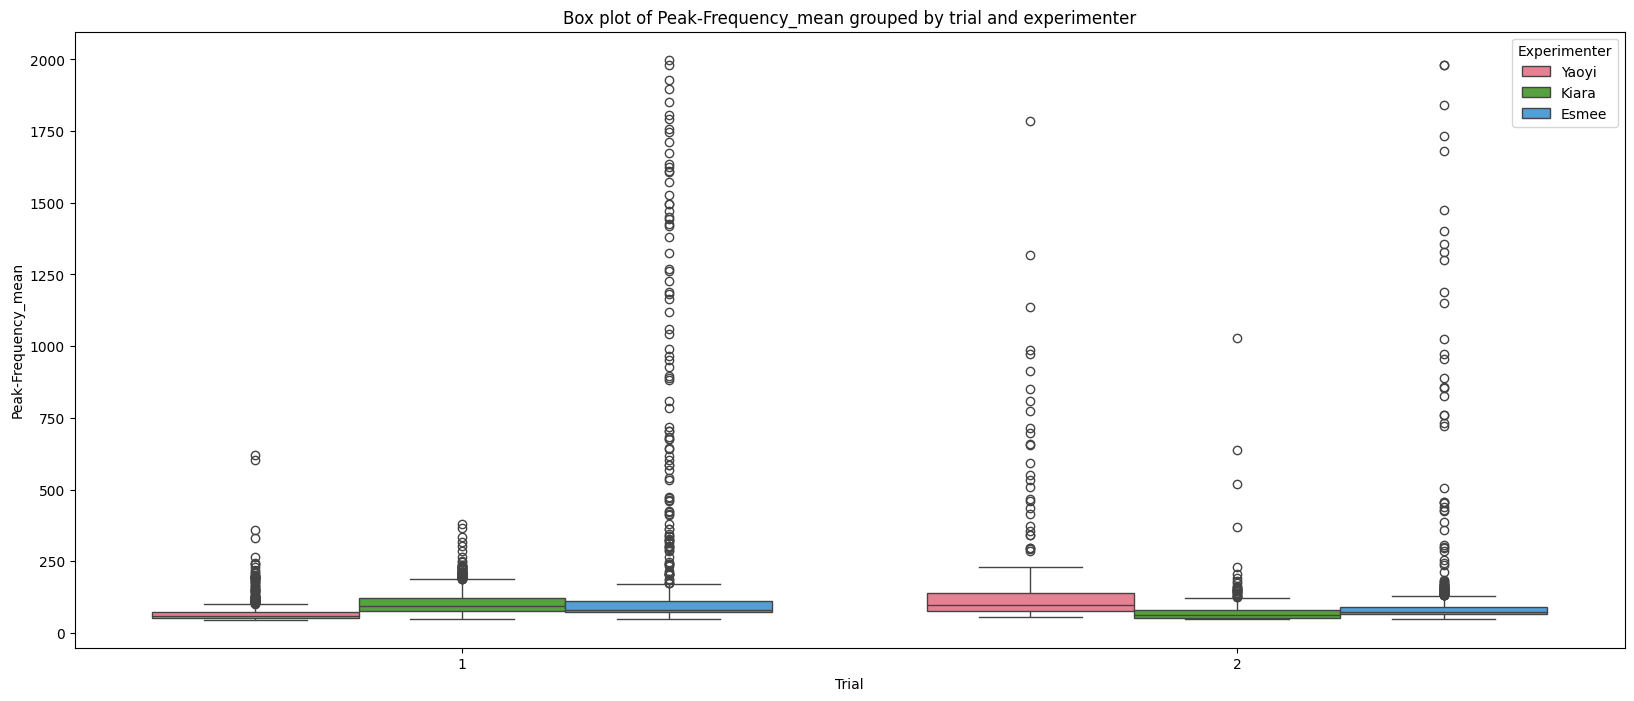

In [54]:
plot_boxplot(final_merged, 'Peak-Frequency_mean')

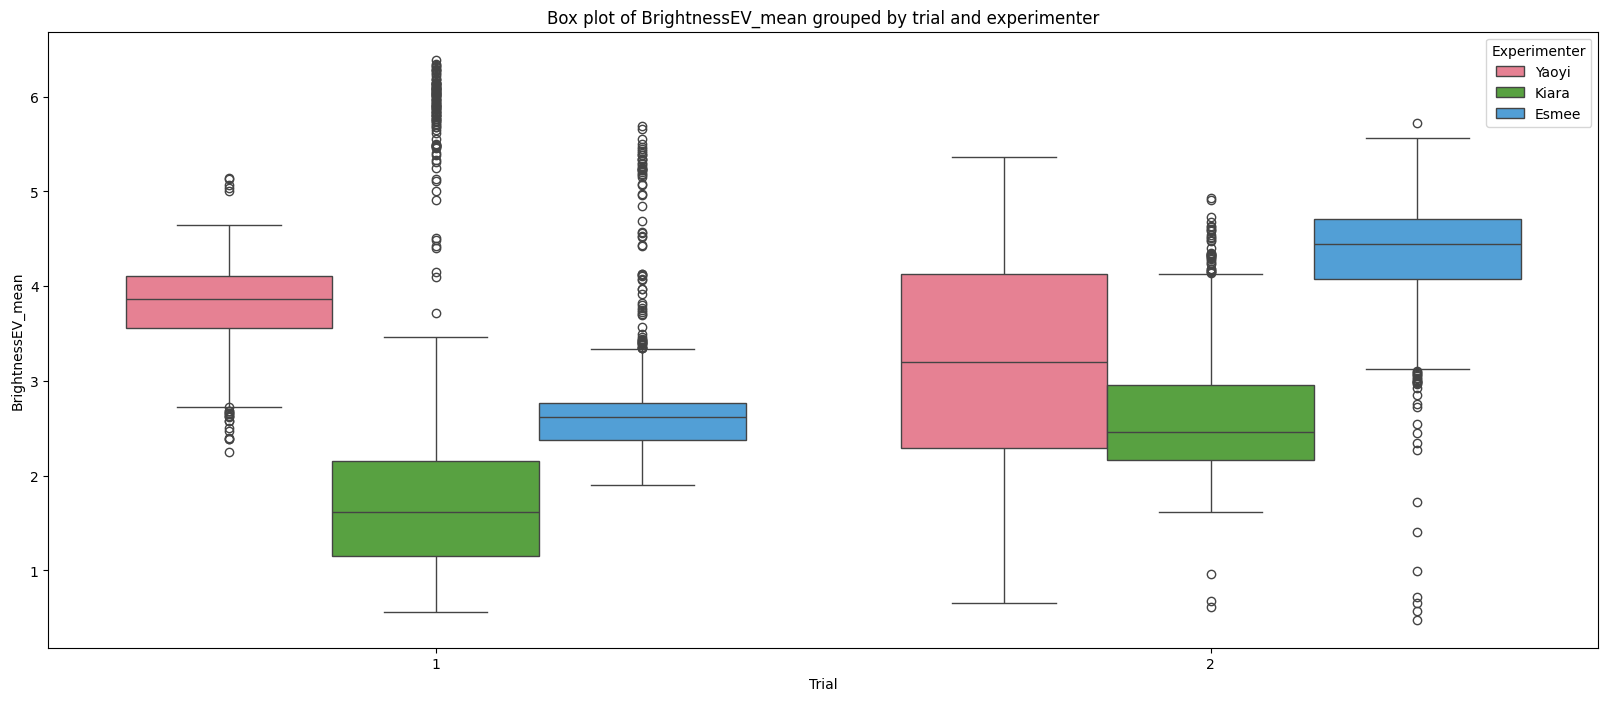

In [55]:
plot_boxplot(final_merged, 'BrightnessEV_mean')

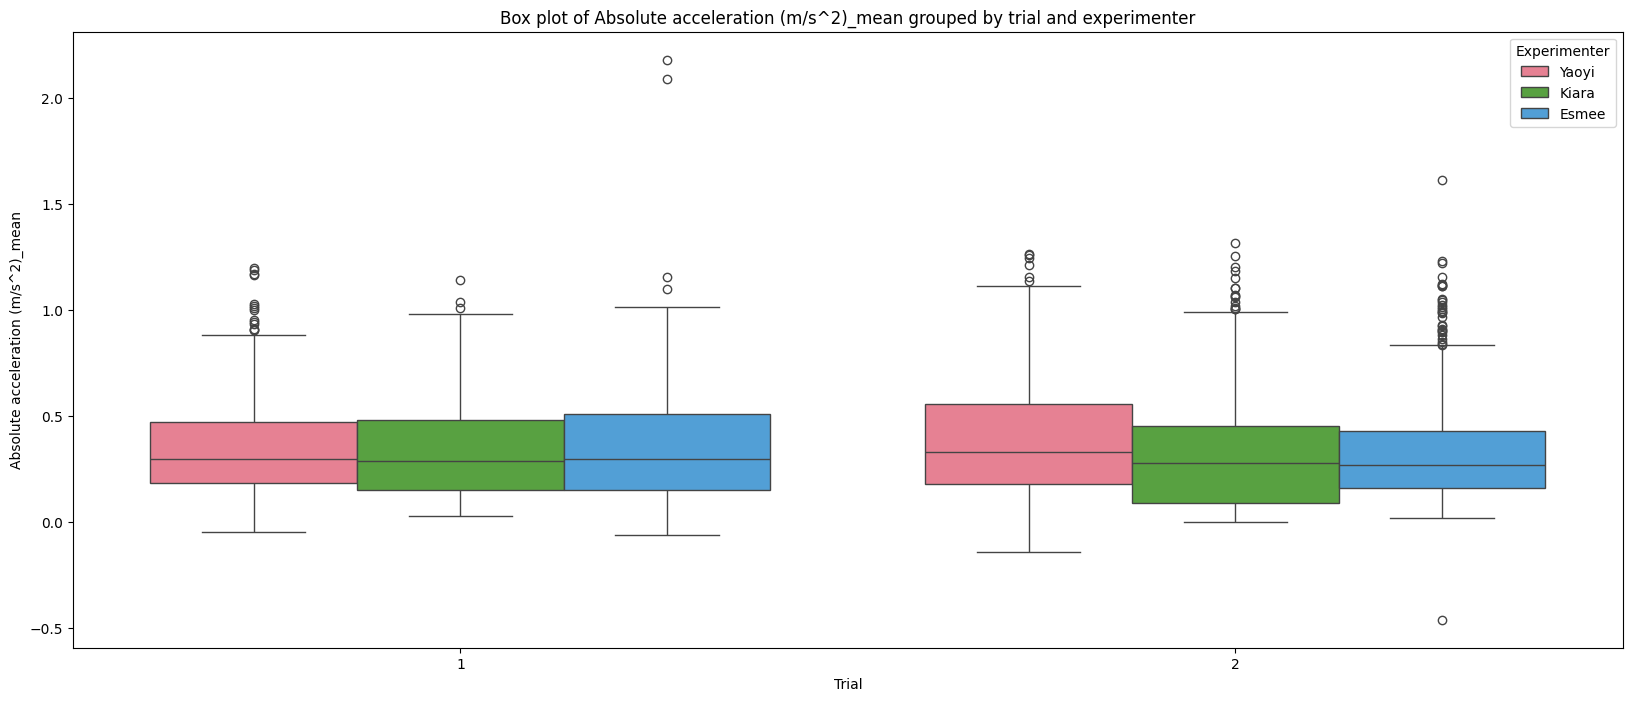

In [56]:
plot_boxplot(final_merged, 'Absolute acceleration (m/s^2)_mean')

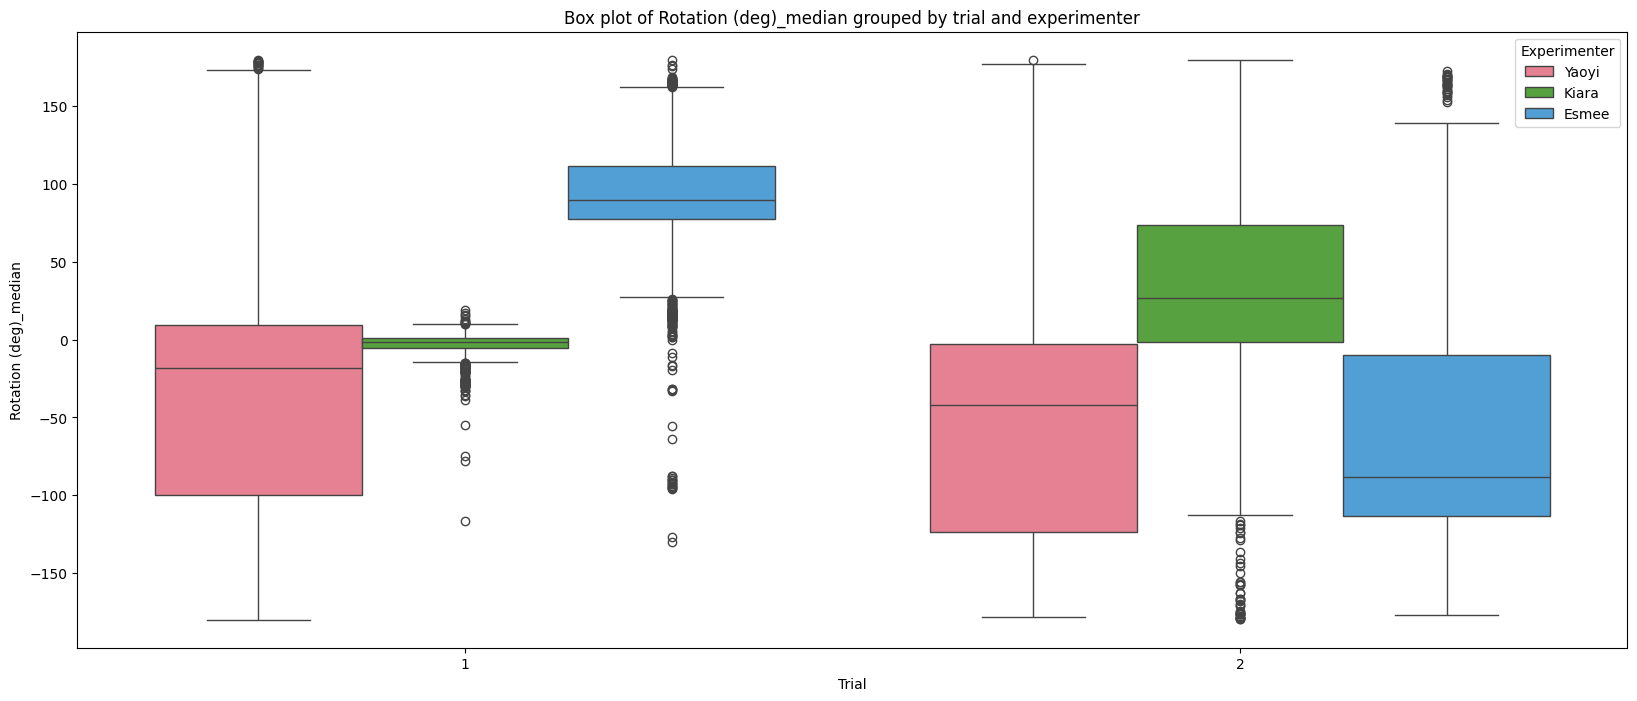

In [57]:
plot_boxplot(final_merged, 'Rotation (deg)_median')

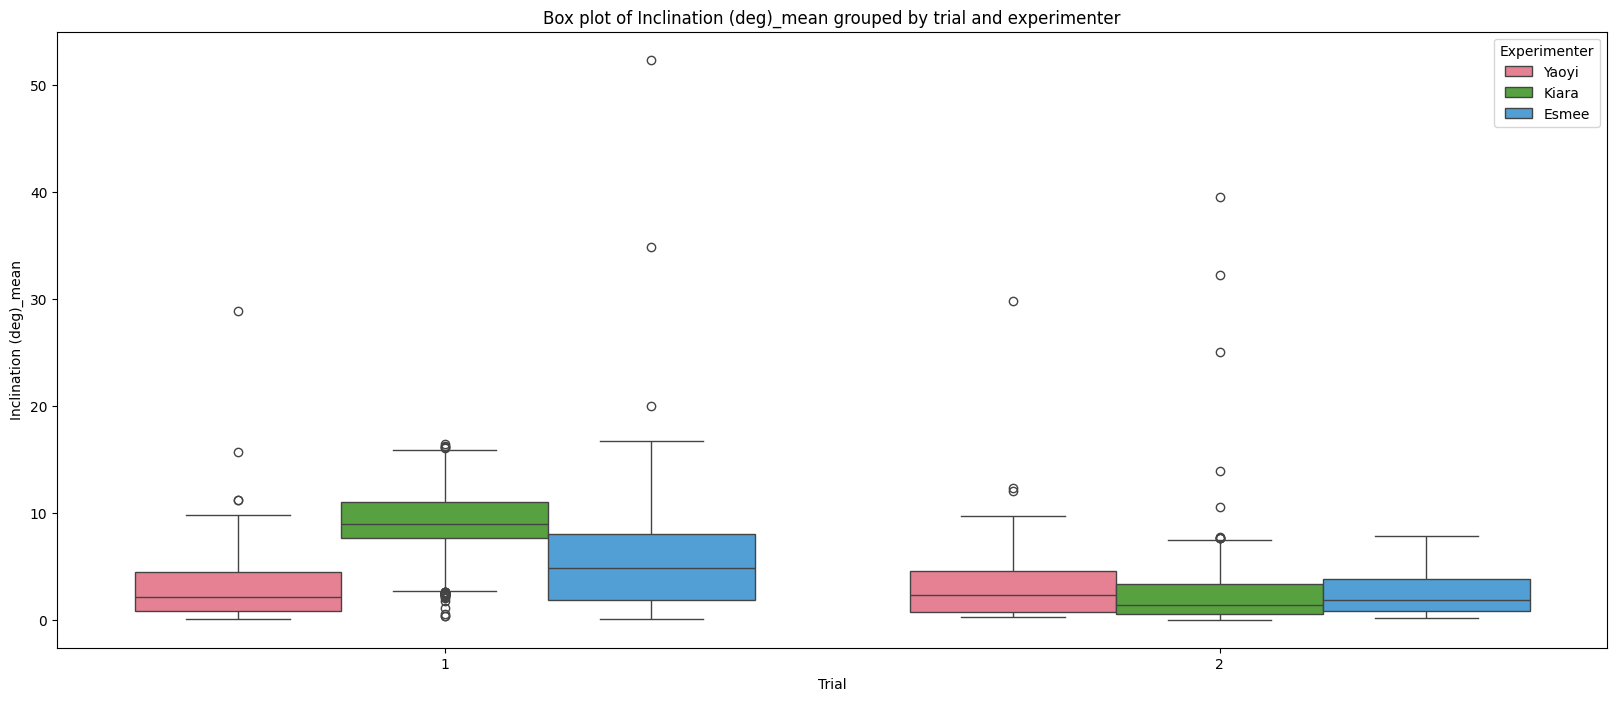

In [58]:
plot_boxplot(final_merged, 'Inclination (deg)_mean')

In [59]:
def plot_linechart(df, sensor_to_be_plotted):

    df = pd.DataFrame(df)

    plt.figure(figsize=(30, 6))
    sns.lineplot(data=df, x='timestamp', y=sensor_to_be_plotted, hue='experimenter', style='trial', markers=True)
    plt.title('Line chart of {} grouped by experimenter and trial'.format(sensor_to_be_plotted))
    plt.xlabel('Timestamp')
    plt.ylabel(sensor_to_be_plotted)
    plt.legend(title='Experimenter')
    plt.show()

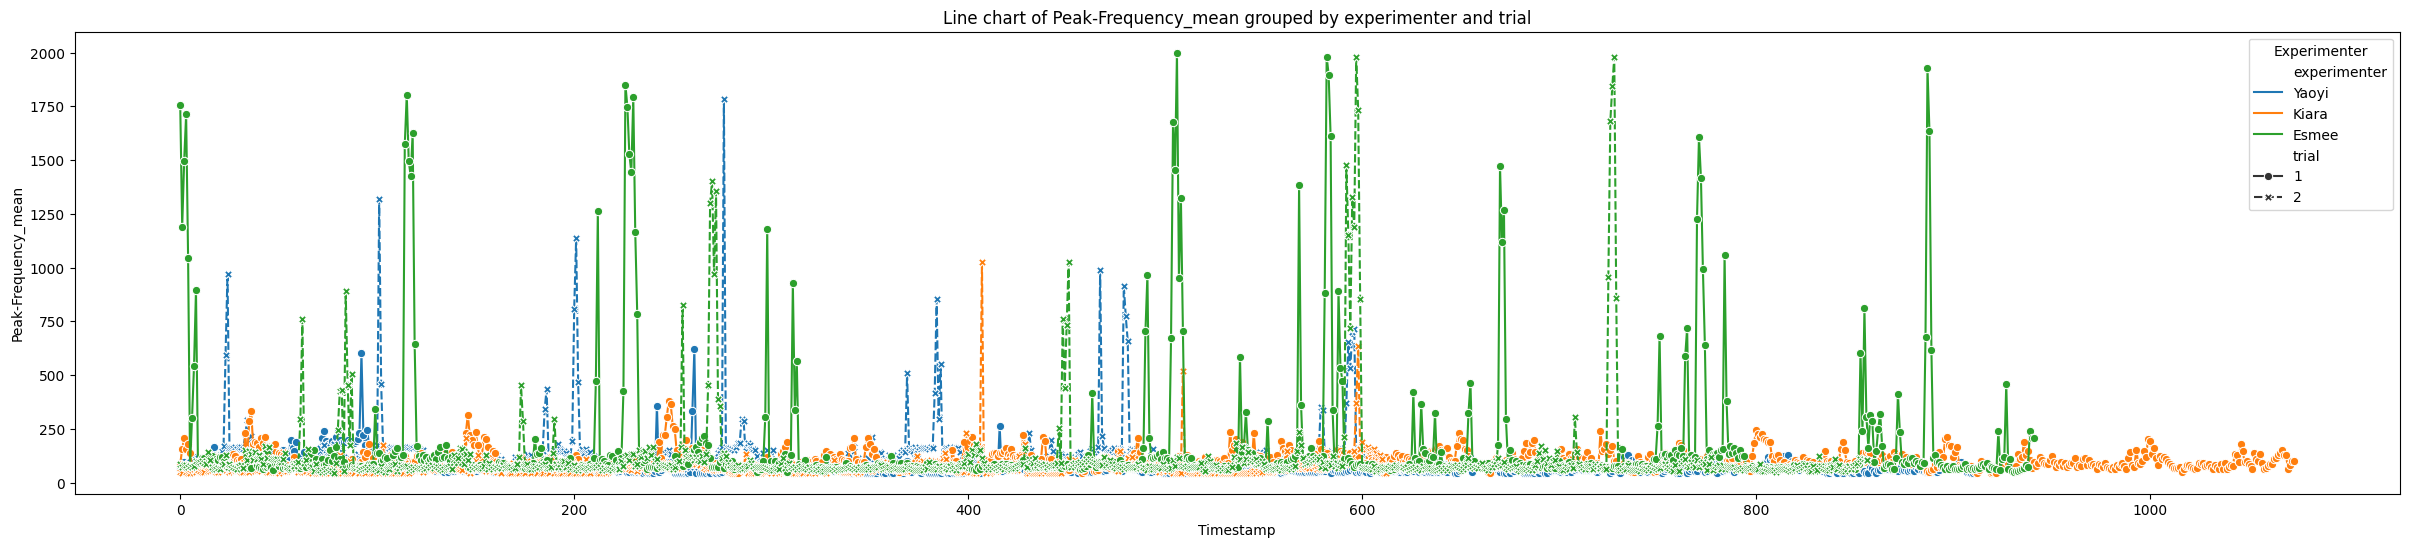

In [60]:
plot_linechart(final_merged, 'Peak-Frequency_mean')

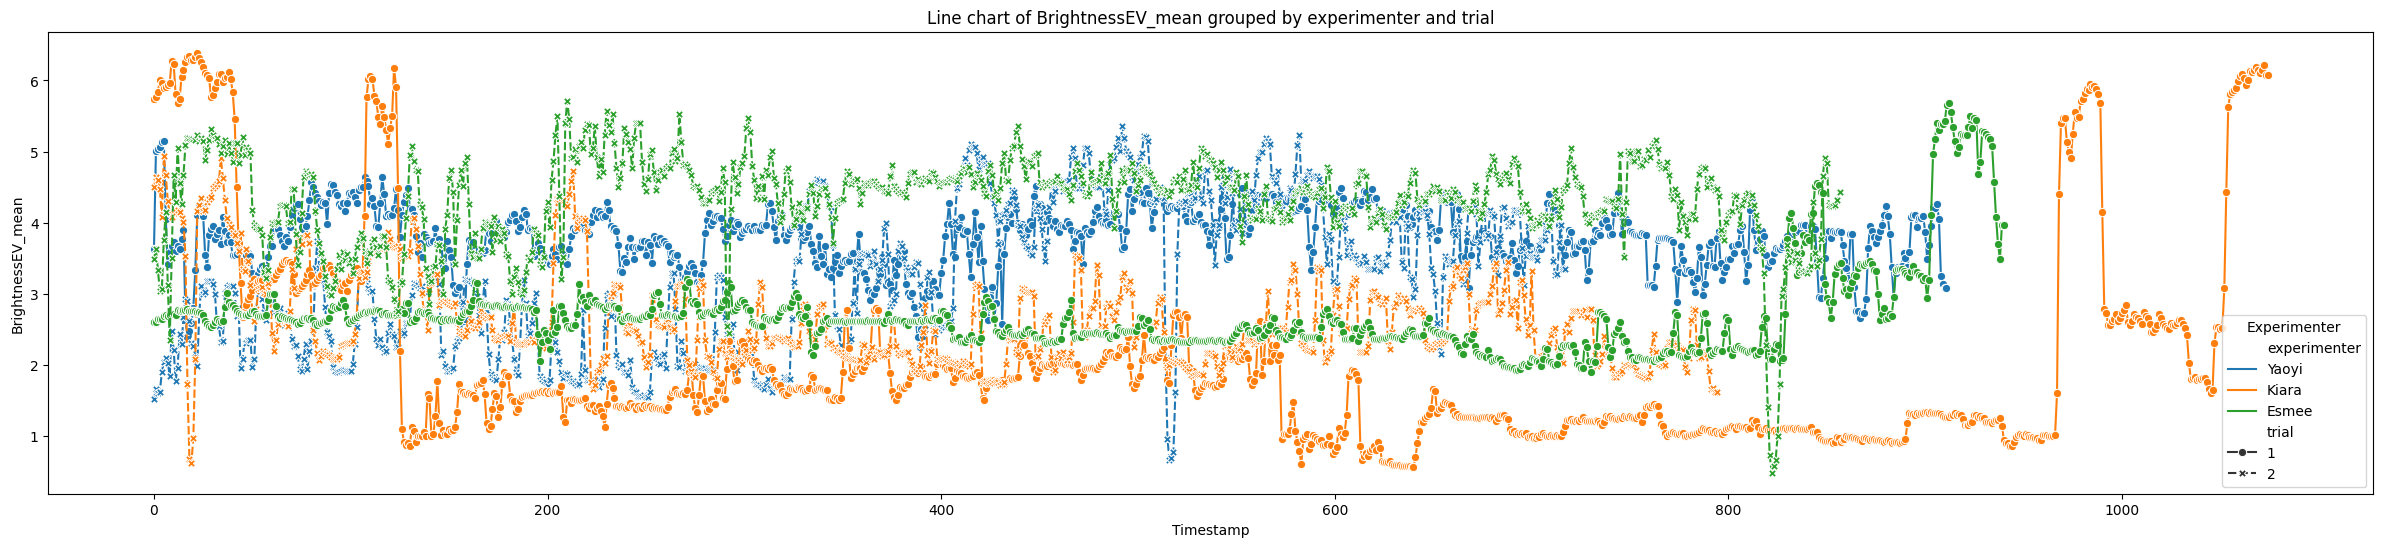

In [61]:
plot_linechart(final_merged, 'BrightnessEV_mean')

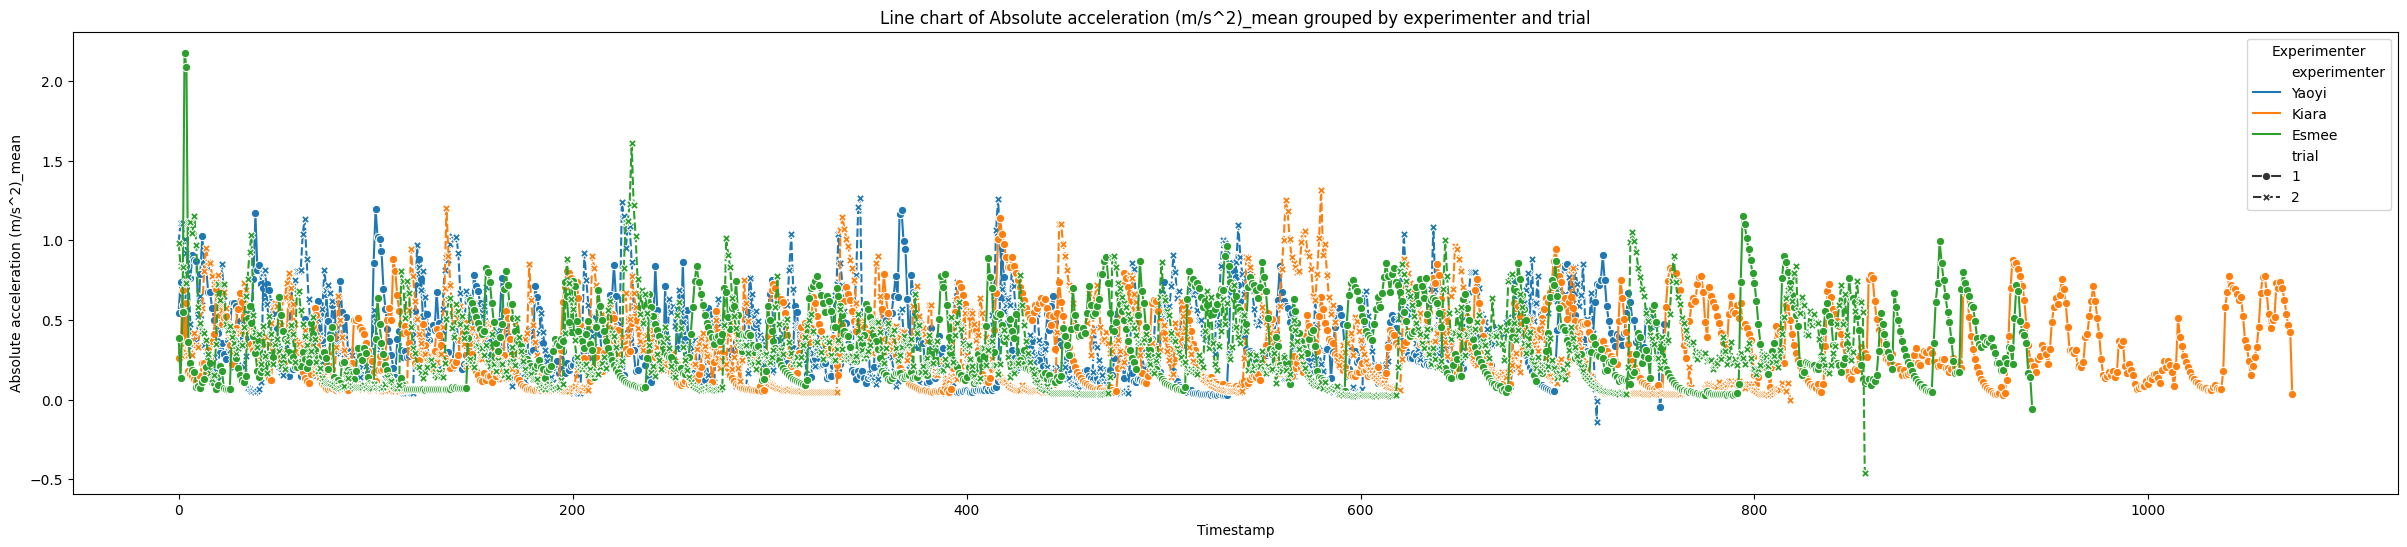

In [62]:
plot_linechart(final_merged, 'Absolute acceleration (m/s^2)_mean')

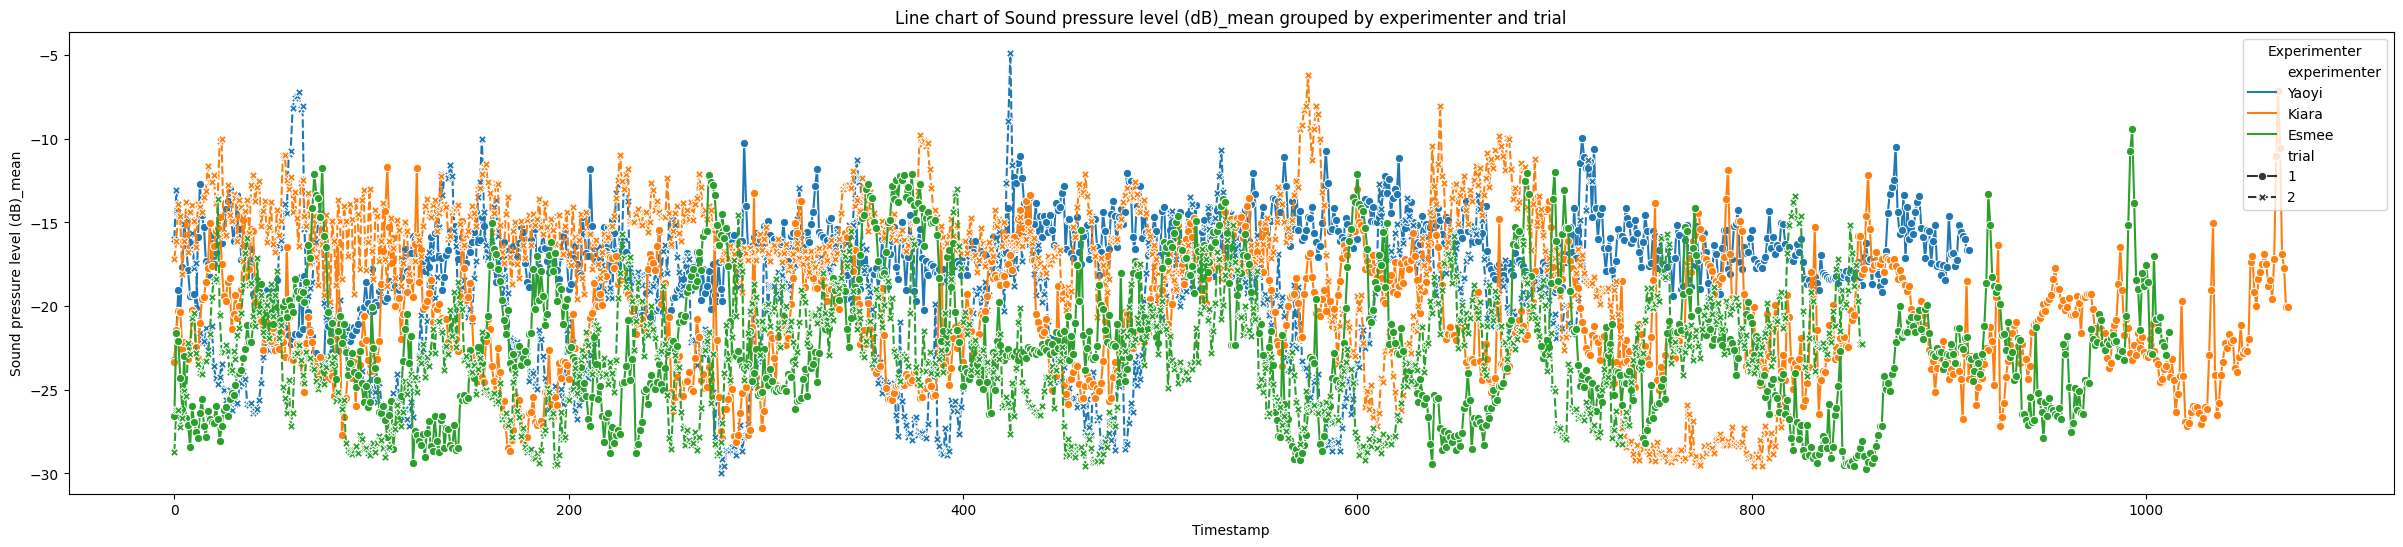

In [63]:
plot_linechart(final_merged, 'Sound pressure level (dB)_mean')

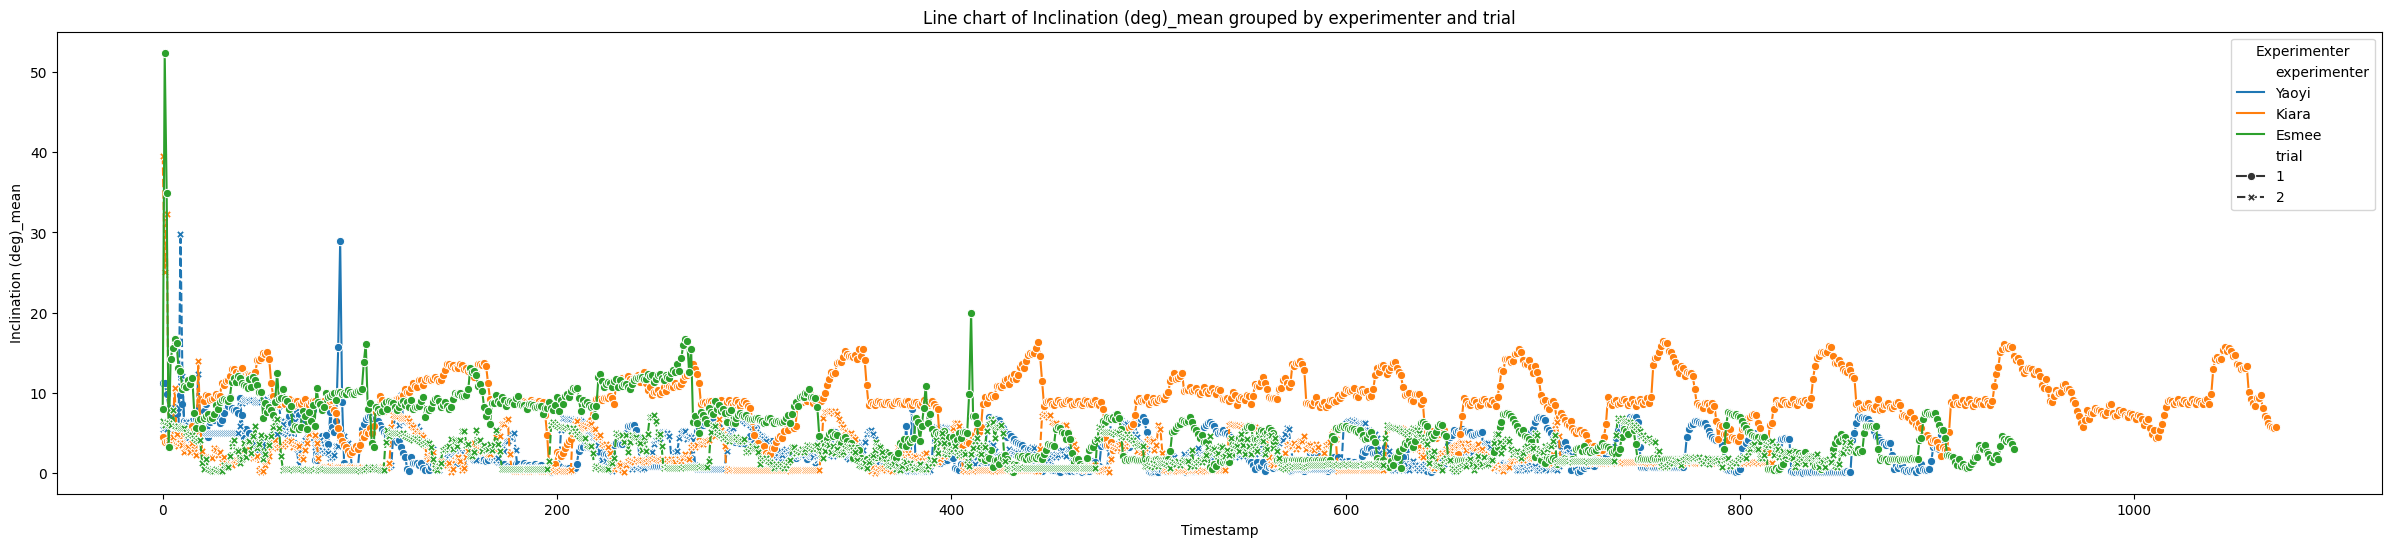

In [64]:
plot_linechart(final_merged, 'Inclination (deg)_mean')

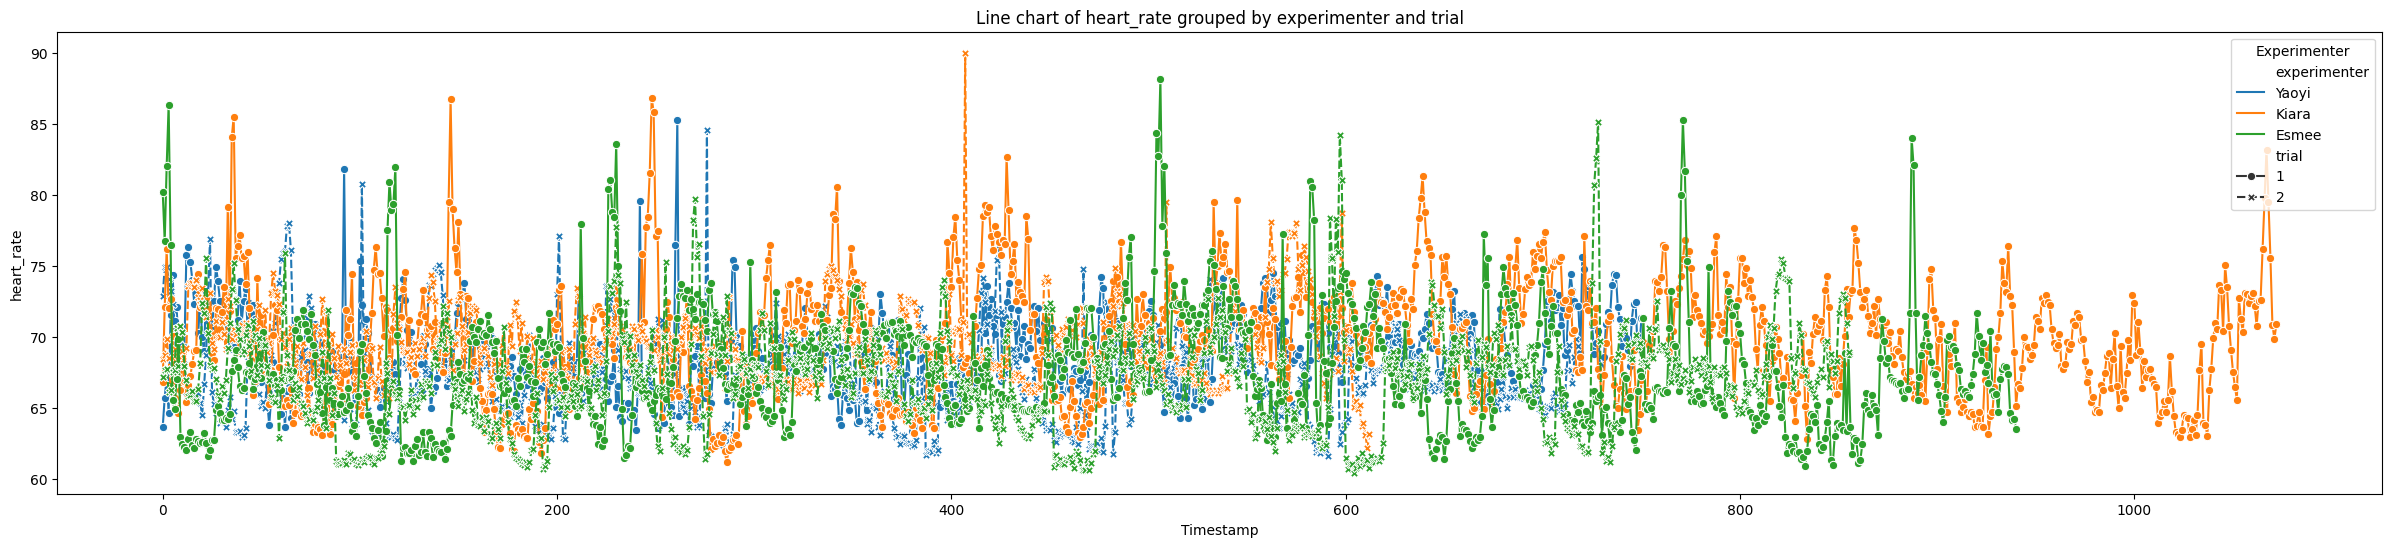

In [65]:
plot_linechart(final_merged, 'heart_rate')

In [66]:
def prepare_data(
    df: pd.DataFrame,
    data: Optional[Union[str, List[str], np.ndarray]] = None,
    ) -> np.ndarray:
    """
    This function prepares the data for plotting.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    column (str): The column name in the DataFrame.
    data (Union[str, List[str], np.ndarray], optional): The data to be plotted. If None,
    all data will be plotted.

    Returns:
    np.ndarray: An array containing the prepared data.
    """
    # If data is not specified, get all unique data
    if data is None:
        data = df.columns.tolist()
    # If data is a single string, make it a list
    elif isinstance(data, str):
        data = [data]

    # Convert data to a numpy array
    data = np.array(data)

    # Assert that data is a numpy array
    assert isinstance(data, np.ndarray), "data must be a numpy array"

    return data

In [67]:
def dot_plots(
    df: pd.DataFrame,
    ids: Optional[Union[str, List[str], np.ndarray]] = None,
    variables: Optional[Union[str, List[str], np.ndarray]] = None,
    mark_outliers: bool = False  # Added parameter for marking outliers
    ) -> None:
    """
    This function plots the change in value for each unique variable over time.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    ids (Union[str, List[str], np.ndarray], optional): The id(s) to be plotted. If None,
    all ids will be plotted.
    variables (Union[str, List[str], np.ndarray], optional): The variable(s) to be
    plotted. If None, all variables will be plotted.
    mark_outliers (bool, optional): Whether to mark outliers with red color.

    Returns:
    None
    """

    ids = prepare_data(df, ids)
    variables = prepare_data(df, variables)
    assert ids is not None
    assert variables is not None

    # Create a Pastel colormap
    pastel_colors = ['#FFCCCC', '#FFCC99', '#FFCC66', '#FFFF66', '#CCFFCC', '#CCFFFF', '#99CCFF',
                     '#9999FF', '#FF99CC', '#FF99FF', '#FFCCFF', '#FF9966', '#FFFF99', '#66FF99',
                     '#66FFFF', '#99CC99', '#99CCCC', '#669999', '#666699', '#6699CC', '#6699FF',
                     '#CCCC99', '#CC9999', '#CC99CC', '#CC99FF', '#CC6699', '#CCCC66']

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(len(variables), 1, figsize=(10, 5 * len(variables)))

    # If there's only one subplot, axs will not be a list. We need to make it a list.
    if len(variables) == 1:
        axs = [axs]

    # Plot the change in value for each unique variable over time
    for i, variable in enumerate(variables):
        df_variable = df[(df.columns[df.columns == variable]) & (df["experimenter"].isin(ids))]
        for idx, id in enumerate(df_variable["experimenter"].unique()):
            df_id = df_variable[df_variable["experimenter"] == id]
            df_id = df_id.sort_values(by='timestamp')  # Sort by time within each group of id and variable
            x = df_id["timestamp"]
            y = df_id[variable]
            for j in range(len(x)):
                if mark_outliers and df_id["outlier"].iloc[j] == 1:  # Check if mark_outliers is True and if the value is an outlier
                    axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color='red', markersize=3)  # Mark outliers with red color
                else:
                    axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color=pastel_colors[idx], markersize=3)
        axs[i].set_title(variable)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

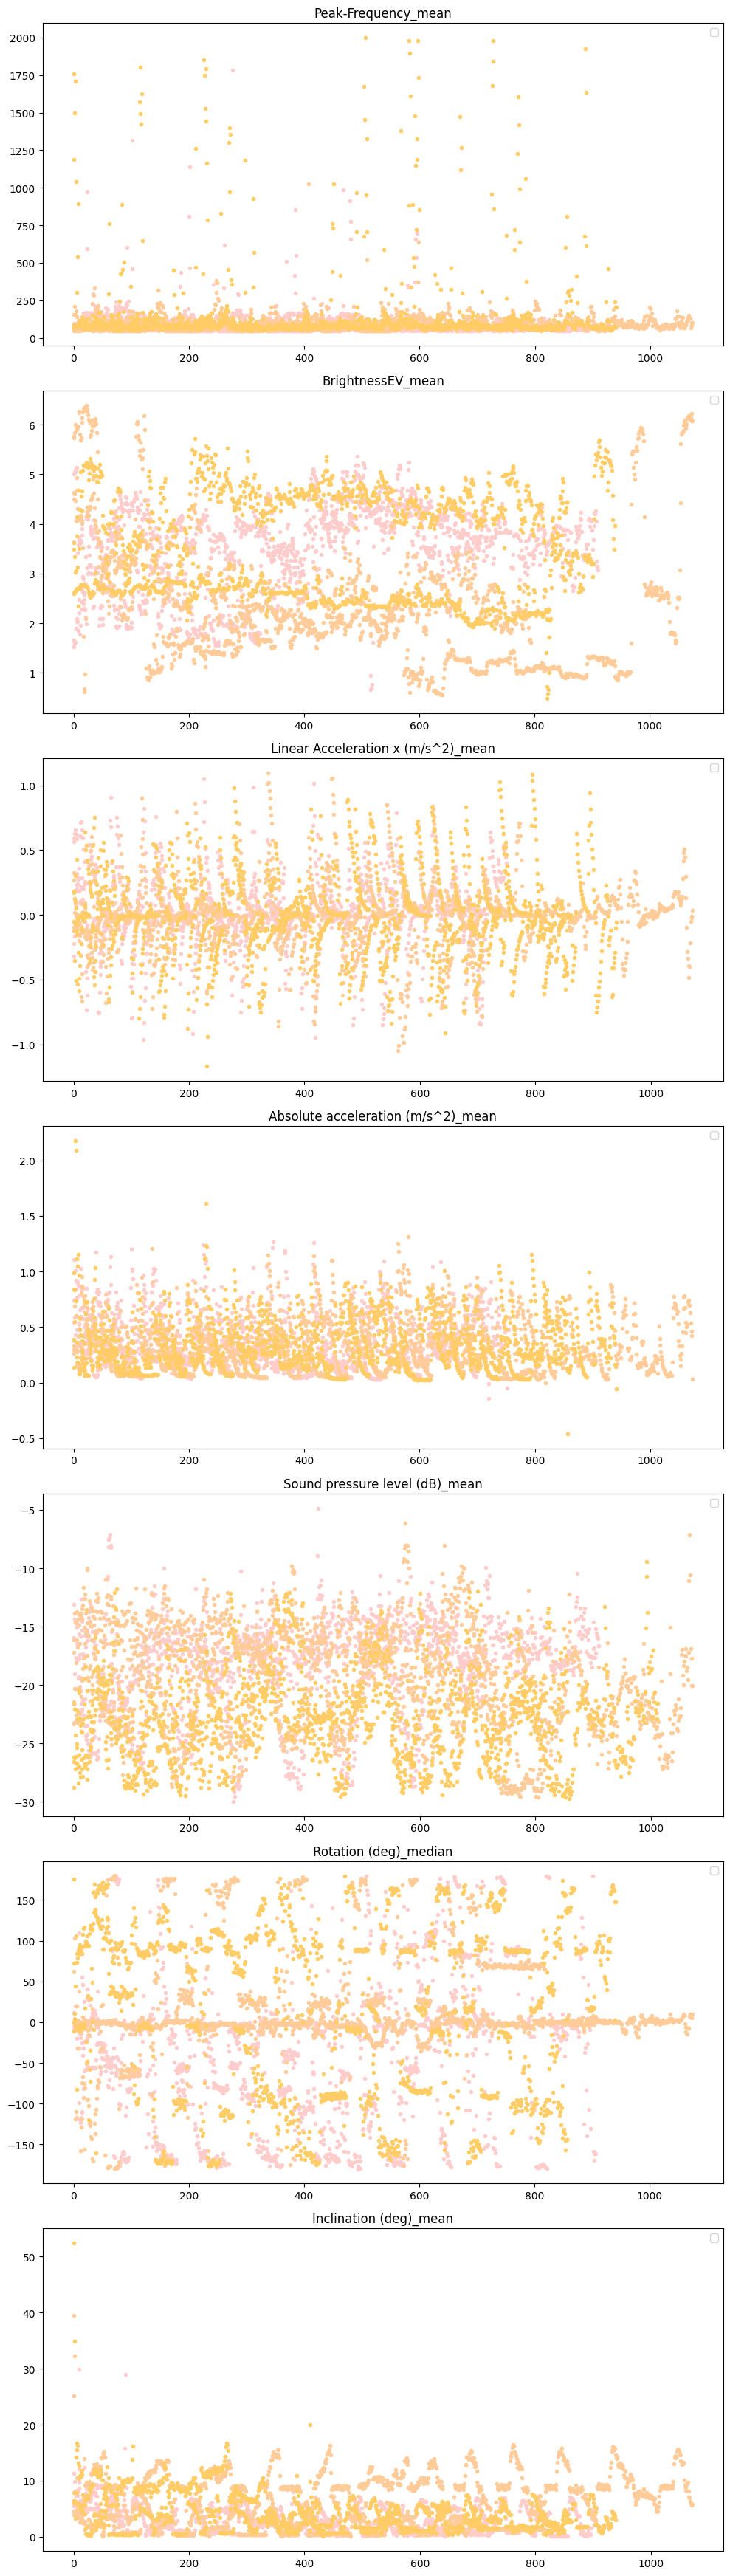

In [68]:
dot_plots(final_merged, ['Yaoyi', 'Esmee', 'Kiara'], ['Peak-Frequency_mean', 'BrightnessEV_mean', 'Linear Acceleration x (m/s^2)_mean', 'Absolute acceleration (m/s^2)_mean', 'Sound pressure level (dB)_mean', 'Rotation (deg)_median', 'Inclination (deg)_mean'])

# **Missing Value**

In [69]:
final_merged.isna().sum()

timestamp                                 1
BrightnessEV_max                        104
BrightnessEV_min                        104
BrightnessEV_median                     104
BrightnessEV_mean                       104
BrightnessEV_std                        106
trial                                     0
experimenter                              0
Peak-Frequency_max                      283
Peak-Frequency_min                      283
Peak-Frequency_median                   283
Peak-Frequency_mean                     283
Peak-Frequency_std                      285
Sound pressure level (dB)_max            10
Sound pressure level (dB)_min            10
Sound pressure level (dB)_median         10
Sound pressure level (dB)_mean           10
Sound pressure level (dB)_std            10
Linear Acceleration x (m/s^2)_max       246
Linear Acceleration x (m/s^2)_min       246
Linear Acceleration x (m/s^2)_median    246
Linear Acceleration x (m/s^2)_mean      246
Linear Acceleration x (m/s^2)_st

# *LOCF*

In [70]:
def interpolate_group(group):
    # group = group.set_index('timestamp')
    group = group.interpolate(method='linear', axis=0)
    group.reset_index(drop=True, inplace=True)
    return group

In [71]:
df_locf = final_merged.copy(deep=True)
groups = df_locf.groupby("experimenter")
df_locf = groups.apply(interpolate_group)
df_locf.reset_index(drop=True, inplace=True)

# *Median*

In [73]:
def fill_missing_values_with_median(df, columns_to_fill):
    # Preserve the original index
    original_index = df.index
    
    # Ensure that 'timestamp' is sorted within each group for correct calculation of nearest timestamps
    df = df.sort_values(by=['experimenter', 'trial', 'timestamp'])
    
    # Function to fill missing values within each group
    def fill_group(group):
        timestamps = group['timestamp'].to_numpy()
        n = len(timestamps)
        
        for column in columns_to_fill:
            values = group[column].to_numpy()
            
            for i in range(n):
                if pd.isna(values[i]):
                    # Find the nearest three timestamps
                    left, right = i - 5, i + 5
                    nearest_values = []
                    
                    # Collect nearest left values
                    while left >= 0 and len(nearest_values) < 3:
                        if not pd.isna(values[left]):
                            nearest_values.append(values[left])
                        left -= 1
                    
                    # Collect nearest right values
                    while right < n and len(nearest_values) < 3:
                        if not pd.isna(values[right]):
                            nearest_values.append(values[right])
                        right += 1
                    
                    # Compute the median of the nearest three values
                    if len(nearest_values) > 0:
                        median_value = np.median(nearest_values)
                        values[i] = median_value
            
            group[column] = values
        
        return group
    
    # Apply the function to each group
    df = df.groupby(['experimenter', 'trial'], group_keys=False).apply(fill_group)
    
    # Restore the original index
    df = df.set_index(original_index)
    return df

In [74]:
columns_to_be_interpolated = list(final_merged.columns)
unaffected_columns = ['timestamp', 'trial', 'experimenter']
for i in unaffected_columns:
    columns_to_be_interpolated.remove(i)

In [75]:
df_median = final_merged.copy(deep=True)
df_median = fill_missing_values_with_median(df_median, columns_to_be_interpolated)
df_median

timestamp  BrightnessEV_max  BrightnessEV_min  BrightnessEV_median  \
0       0.000000          2.614682          2.590836             2.598828   
1       1.000000          2.630364          2.566588             2.614682   
2       2.000000          2.661225          2.622545             2.638141   
3       3.000000          2.653571          2.638141             2.653571   
4       4.000000          2.668838          2.638141             2.645877   
...          ...               ...               ...                  ...   
5399  718.000000          3.316994          3.233336             3.263955   
5400  719.000000          3.316994          3.233336             3.263955   
5401  720.000000          4.072522          3.330477             3.762476   
5402  720.085676          4.072522          3.346145             3.762476   
5403         NaN          3.364396          3.346145             3.353096   

      BrightnessEV_mean  BrightnessEV_std trial experimenter  \
0              2.600805          0.006804     1        Esmee   
1              2.606115          0.020364     1        Esmee   
2              2.642755          0.010039     1        Esmee   
3              2.647918          0.006817     1        Esmee   
4              2.649440          0.009991     1        Esmee   
...                 ...               ...   ...          ...   
5399           3.272730          0.027808     2        Yaoyi   
5400           3.272730          0.027808     2        Yaoyi   
5401           3.730140          0.230926     2        Yaoyi   
5402           3.730140          0.230926     2        Yaoyi   
5403           3.353767          0.007031     2        Yaoyi   

      Peak-Frequency_max  Peak-Frequency_min  ...  Inclination (deg)_min  \
0              1757.8125           1757.8125  ...               7.939696   
1              2203.1250             46.8750  ...              48.666906   
2              2203.1250             46.8750  ...              22.788425   
3              2203.1250             70.3125  ...               1.777635   
4              2203.1250             46.8750  ...               5.400174   
...                  ...                 ...  ...                    ...   
5399             93.7500             46.8750  ...               2.326561   
5400             70.3125             23.4375  ...               2.326561   
5401             70.3125             46.8750  ...               2.247643   
5402             70.3125             46.8750  ...               2.247643   
5403            140.6250             46.8750  ...               2.261942   

      Inclination (deg)_median  Inclination (deg)_mean  Inclination (deg)_std  \
0                     7.939696                7.939696               2.497690   
1                    52.390605               52.390605               5.266105   
2                    34.900274               34.900274              17.128741   
3                     3.256084                3.256084               2.090842   
4                    14.200188               14.200188              12.445098   
...                        ...                     ...                    ...   
5399                  2.393080                2.393080               0.307798   
5400                  2.393080                2.393080               0.307798   
5401                  2.291738                2.291738               0.273859   
5402                  2.291738                2.291738               0.144099   
5403                  2.331203                2.331203               0.144099   

      Rotation (deg)_max  Rotation (deg)_min  Rotation (deg)_median  \
0             175.802332          175.802332             175.802332   
1              73.339843           72.144628              72.742236   
2              85.402887          -63.487116              10.957885   
3              74.525987           15.118749              44.822368   
4             114.958296           97.226833             106.092565   
.

# **Outlier**

### Kalman

In [76]:
df_kalman = df_median.copy(deep=True)
outlier = KalmanFilters()
for i in columns_to_be_interpolated:
    df_kalman = outlier.apply_kalman_filter(df_kalman, i)

In [77]:
def replace_columns_with_kalman(df):
    
    columns_to_drop = []
    kalman_columns = []

    for col in df.columns:
        if col.endswith(('_max', '_min', '_median', '_std', '_mean')):
            columns_to_drop.append(col)
            kalman_col = col + '_kalman'
            if kalman_col in df.columns:
                kalman_columns.append(kalman_col)
            else:
                raise ValueError(f"Kalman column {kalman_col} does not exist for {col}")

    # Drop the original columns
    df = df.drop(columns=columns_to_drop)
    
    # Rename the _kalman columns to the original column names
    kalman_columns_rename = {kalman: kalman.replace('_kalman', '') for kalman in kalman_columns}
    df = df.rename(columns=kalman_columns_rename)

    return df

In [78]:
df = replace_columns_with_kalman(df_kalman)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

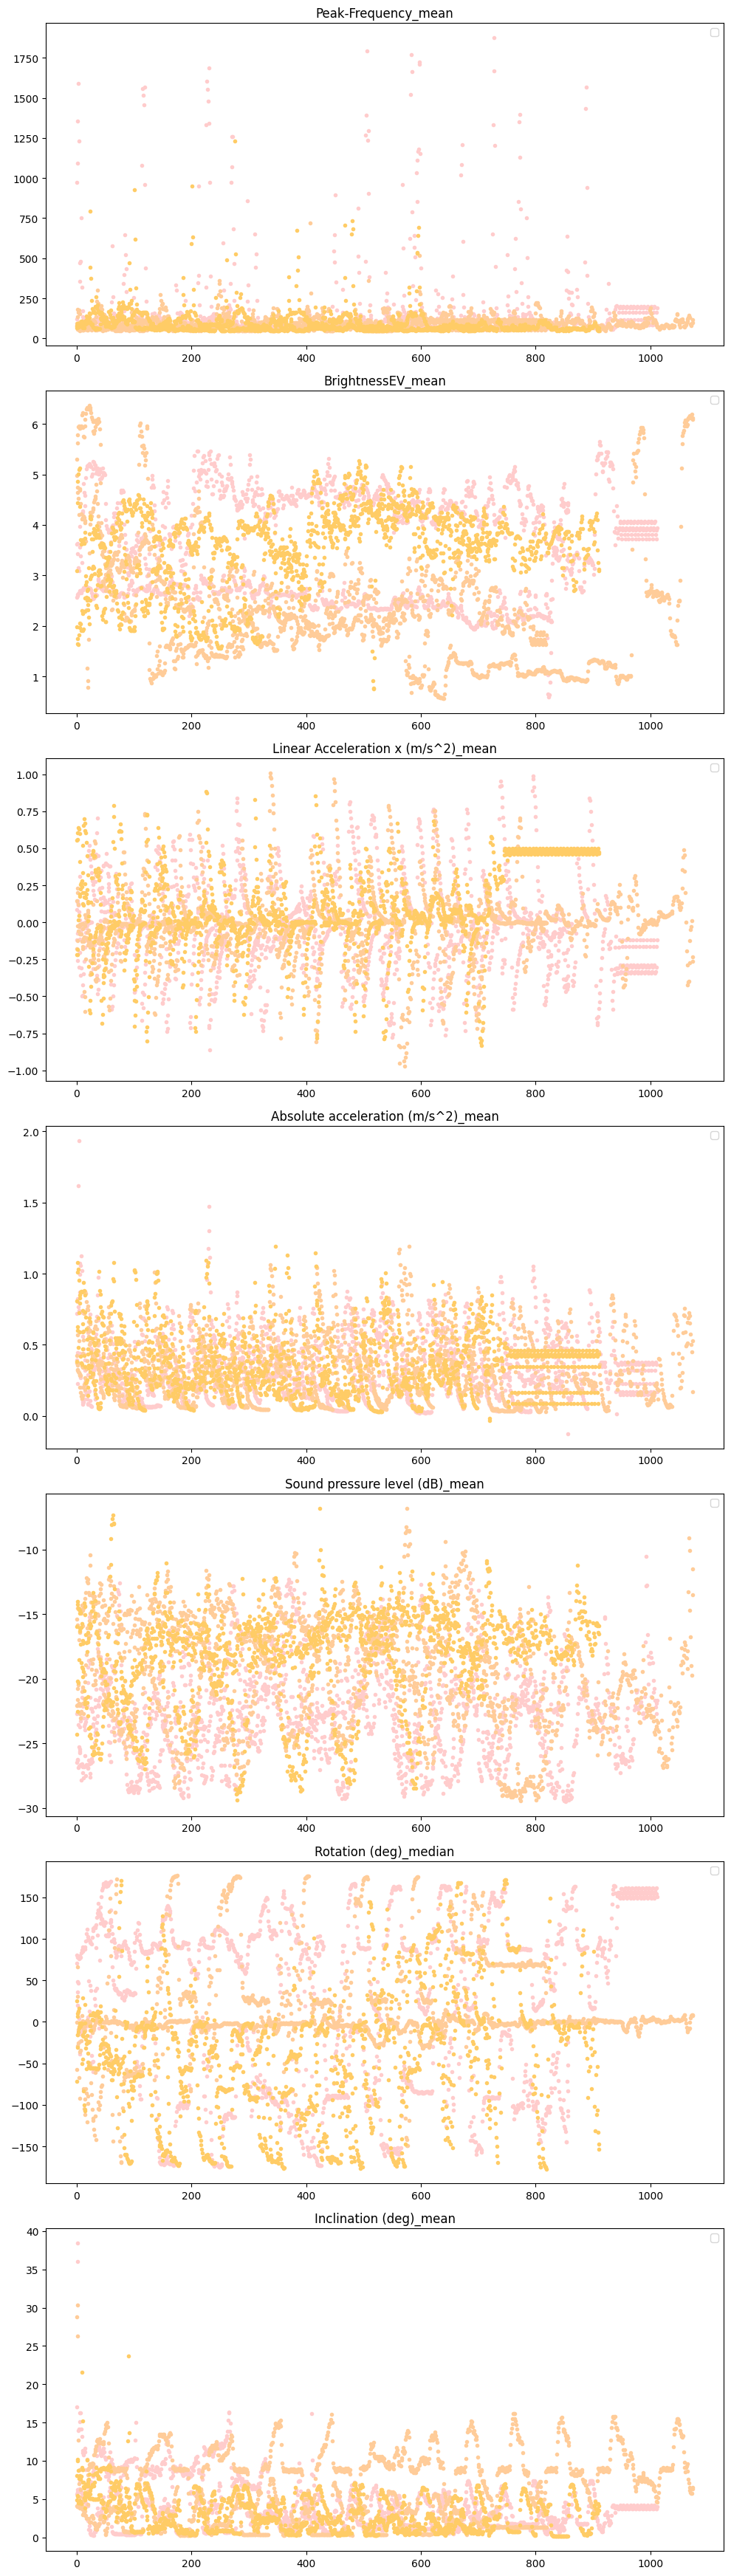

In [79]:
dot_plots(df, ['Yaoyi', 'Esmee', 'Kiara'], ['Peak-Frequency_mean', 'BrightnessEV_mean', 'Linear Acceleration x (m/s^2)_mean', 'Absolute acceleration (m/s^2)_mean', 'Sound pressure level (dB)_mean', 'Rotation (deg)_median', 'Inclination (deg)_mean'])

### Distance Based

In [80]:
# df_distance_based = df_median.copy(deep=True)
# outlier2 = DistanceBasedOutlierDetection()
# outlier2.local_outlier_factor(df_distance_based, columns_to_be_interpolated, 'euclidean', 5)

### Distribution Based:

In [81]:
# class DistributionBasedOutlierDetection:

#     # Finds outliers in the specified column of datatable and adds a binary column with
#     # the same name extended with '_outlier' that expresses the result per data point.
#     def chauvenet(self, data_table, col, C):
#         # Taken partly from: https://www.astro.rug.nl/software/kapteyn/

#         # Computer the mean and standard deviation.
#         mean = data_table[col].mean()
#         std = data_table[col].std()
#         N = len(data_table.index)
#         criterion = 1.0/(C*N)

#         # Consider the deviation for the data points.
#         deviation = abs(data_table[col] - mean)/std

#         # Express the upper and lower bounds.
#         low = -deviation/math.sqrt(C)
#         high = deviation/math.sqrt(C)
#         prob = []
#         mask = []

#         # Pass all rows in the dataset.
#         for i in range(0, len(data_table.index)):
#             # Determine the probability of observing the point
#             prob.append(
#                 1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i])))
#             # And mark as an outlier when the probability is below our criterion.
#             mask.append(prob[i] < criterion)
#         data_table[col + '_outlier'] = mask
#         return data_table

#     # Fits a mixture model towards the data expressed in col and adds a column with the probability
#     # of observing the value given the mixture model.
#     def mixture_model(self, data_table, col):
#         print('Applying mixture models')
        
#         # Fit a mixture model to our data.
#         data = data_table[data_table[col].notnull()][col]
#         g = GaussianMixture(n_components=3, max_iter=100, n_init=1)
#         reshaped_data = np.array(data.values.reshape(-1, 1))
#         g.fit(reshaped_data)
    
#         # Predict the log probabilities
#         log_probs = g.score_samples(reshaped_data)
        
#         # Convert log probabilities to probabilities
#         probs = np.exp(log_probs)
    
#         # Create the data frame with probabilities
#         data_probs = pd.DataFrame(probs, index=data.index, columns=[col+'_mixture'])
    
#         # Concatenate the probabilities with the original data table
#         data_table = pd.concat([data_table, data_probs], axis=1)
        
#         # Define a threshold for outliers
#         threshold = np.percentile(probs, 5)
        
#         # Create a column to mark outliers with True or False
#         data_table[col + '_outlier'] = data_table[col + '_mixture'] < threshold
    
#         return data_table

In [82]:
# outlier = DistributionBasedOutlierDetection()
# df_with_outlier = outlier.mixture_model(final_merged, 'Peak-Frequency_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'BrightnessEV_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Linear Acceleration x (m/s^2)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Absolute acceleration (m/s^2)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Sound pressure level (dB)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Inclination (deg)_mean')
# df_with_outlier = outlier.mixture_model(df_with_outlier, 'Rotation (deg)_median')

In [83]:
# df_with_outlier

In [84]:
# from matplotlib.lines import Line2D

# def dot_plots_legend(
#     df: pd.DataFrame,
#     ids: Optional[Union[str, List[str], np.ndarray]] = None,
#     variables: Optional[Union[str, List[str], np.ndarray]] = None,
#     mark_outliers: bool = False  # Added parameter for marking outliers
#     ) -> None:
#     """
#     This function plots the change in value for each unique variable over time.

#     Parameters:
#     df (pandas.DataFrame): The DataFrame containing the data.
#     ids (Union[str, List[str], np.ndarray], optional): The id(s) to be plotted. If None,
#     all ids will be plotted.
#     variables (Union[str, List[str], np.ndarray], optional): The variable(s) to be
#     plotted. If None, all variables will be plotted.
#     mark_outliers (bool, optional): Whether to mark outliers with red color.

#     Returns:
#     None
#     """

#     ids = prepare_data(df, ids)
#     variables = prepare_data(df, variables)
#     assert ids is not None
#     assert variables is not None

#     # Create a Pastel colormap
#     pastel_colors = ['#FFCCCC', '#FFCC99', '#FFCC66', '#FFFF66', '#CCFFCC', '#CCFFFF', '#99CCFF',
#                      '#9999FF', '#FF99CC', '#FF99FF', '#FFCCFF', '#FF9966', '#FFFF99', '#66FF99',
#                      '#66FFFF', '#99CC99', '#99CCCC', '#669999', '#666699', '#6699CC', '#6699FF',
#                      '#CCCC99', '#CC9999', '#CC99CC', '#CC99FF', '#CC6699', '#CCCC66']

#     # Create a figure and a set of subplots
#     fig, axs = plt.subplots(len(variables), 1, figsize=(10, 5 * len(variables)))

#     # If there's only one subplot, axs will not be a list. We need to make it a list.
#     if len(variables) == 1:
#         axs = [axs]

#     # Plot the change in value for each unique variable over time
#     for i, variable in enumerate(variables):
#         df_variable = df[(df.columns[df.columns == variable]) & (df["experimenter"].isin(ids))]
#         for idx, id in enumerate(df_variable["experimenter"].unique()):
#             df_id = df_variable[df_variable["experimenter"] == id]
#             df_id = df_id.sort_values(by='timestamp')  # Sort by time within each group of id and variable
#             x = df_id["timestamp"]
#             y = df_id[variable]
#             for j in range(len(x)):
#                 if mark_outliers:
#                     # Determine the outlier column name based on the variable
#                     outlier_column = f"{variable}_outlier"
#                     # Check if the value is an outlier in the respective column
#                     if df_id[outlier_column].iloc[j] == 1:
#                         axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color='red', markersize=3)  # Mark outliers with red color
#                     else:
#                         axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color=pastel_colors[idx], markersize=3)
#                 else:
#                     axs[i].plot(x.iloc[j], y.iloc[j], marker='o', color=pastel_colors[idx], markersize=3)
#         axs[i].set_title(variable)

#         if mark_outliers:
#             legend_elements = [Line2D([0], [0], marker='o', color='red', label='Outliers', markersize=5, linestyle='')]
#             axs[i].legend(handles=legend_elements, scatterpoints=1)

#     plt.tight_layout()
#     plt.show()

In [85]:
# dot_plots_legend(df_with_outlier, ['Yaoyi', 'Esmee', 'Kiara'], ['Peak-Frequency_mean', 'BrightnessEV_mean', 'Linear Acceleration x (m/s^2)_mean', 'Absolute acceleration (m/s^2)_mean', 'Sound pressure level (dB)_mean', 'Rotation (deg)_median', 'Inclination (deg)_mean'], mark_outliers=True)

In [86]:
# print(f"{len(df_with_outlier[df_with_outlier['Peak-Frequency_mean_outlier'] == 1])} Peak-Frequency_mean outliers were found")

In [87]:
# def replace_outliers_neighborhood_avg(data_frame, attributes_column='Peak-Frequency_mean', outlier_column_name='Peak-Frequency_mean_outlier'):
#     modified_data = data_frame.copy()
    
#     outlier_indices = modified_data.index[modified_data[outlier_column_name] == True].tolist()
    
#     for outlier_index in outlier_indices:
#         outlier_trial = modified_data.at[outlier_index, 'trial']
#         outlier_experimenter = modified_data.at[outlier_index, 'experimenter']
        
#         same_trial_experimenter_data = modified_data[
#             (modified_data['trial'] == outlier_trial) &
#             (modified_data['experimenter'] == outlier_experimenter)
#         ]
        
#         distances = cdist(
#             same_trial_experimenter_data[[attributes_column]],
#             same_trial_experimenter_data[[attributes_column]],
#             metric='euclidean'
#         )

#         neighborhood_threshold = 5 * np.std(same_trial_experimenter_data[attributes_column])
#         neighborhood_indices = np.where(distances <= neighborhood_threshold)[0]
#         neighborhood_mean = np.mean(same_trial_experimenter_data.iloc[neighborhood_indices][attributes_column])
        
#         # Change the attributes_column based on the outlier_column
#         modified_data.at[outlier_index, attributes_column] = neighborhood_mean
        
#         # Update the outlier column to indicate the outlier has been replaced
#         modified_data.at[outlier_index, outlier_column_name] = False
    
#     return modified_data


In [88]:
# df = replace_outliers_neighborhood_avg(df_with_outlier)

In [89]:
# df

# **Noise**

## Low Pass Filter

In [90]:
lpf = LowPassFilter()
for i in columns_to_be_interpolated:
    df = lpf.low_pass_filter(df, i, 0.01, 0.003)

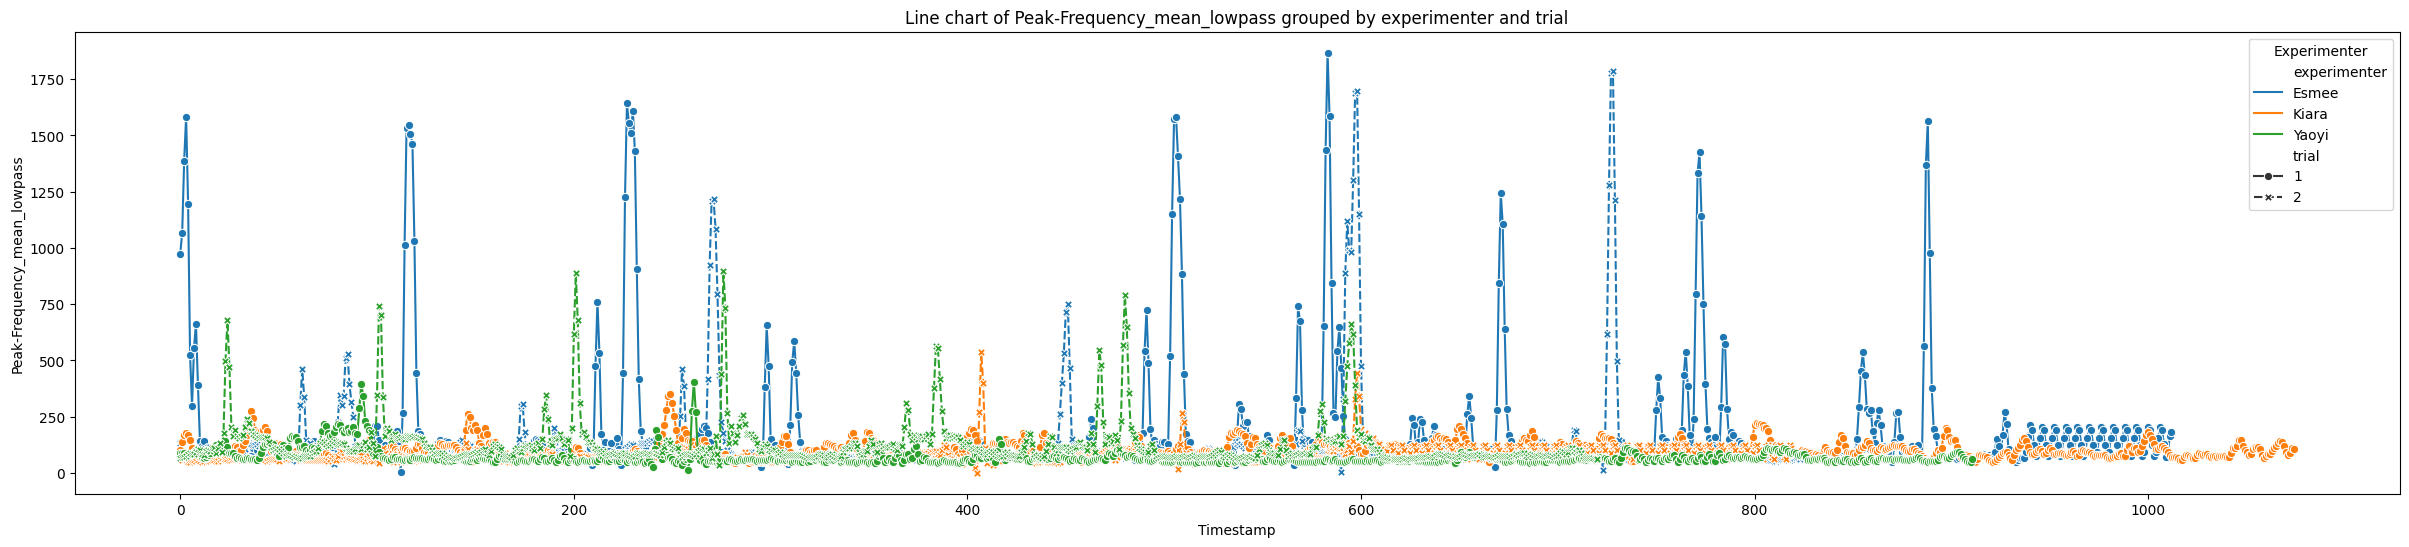

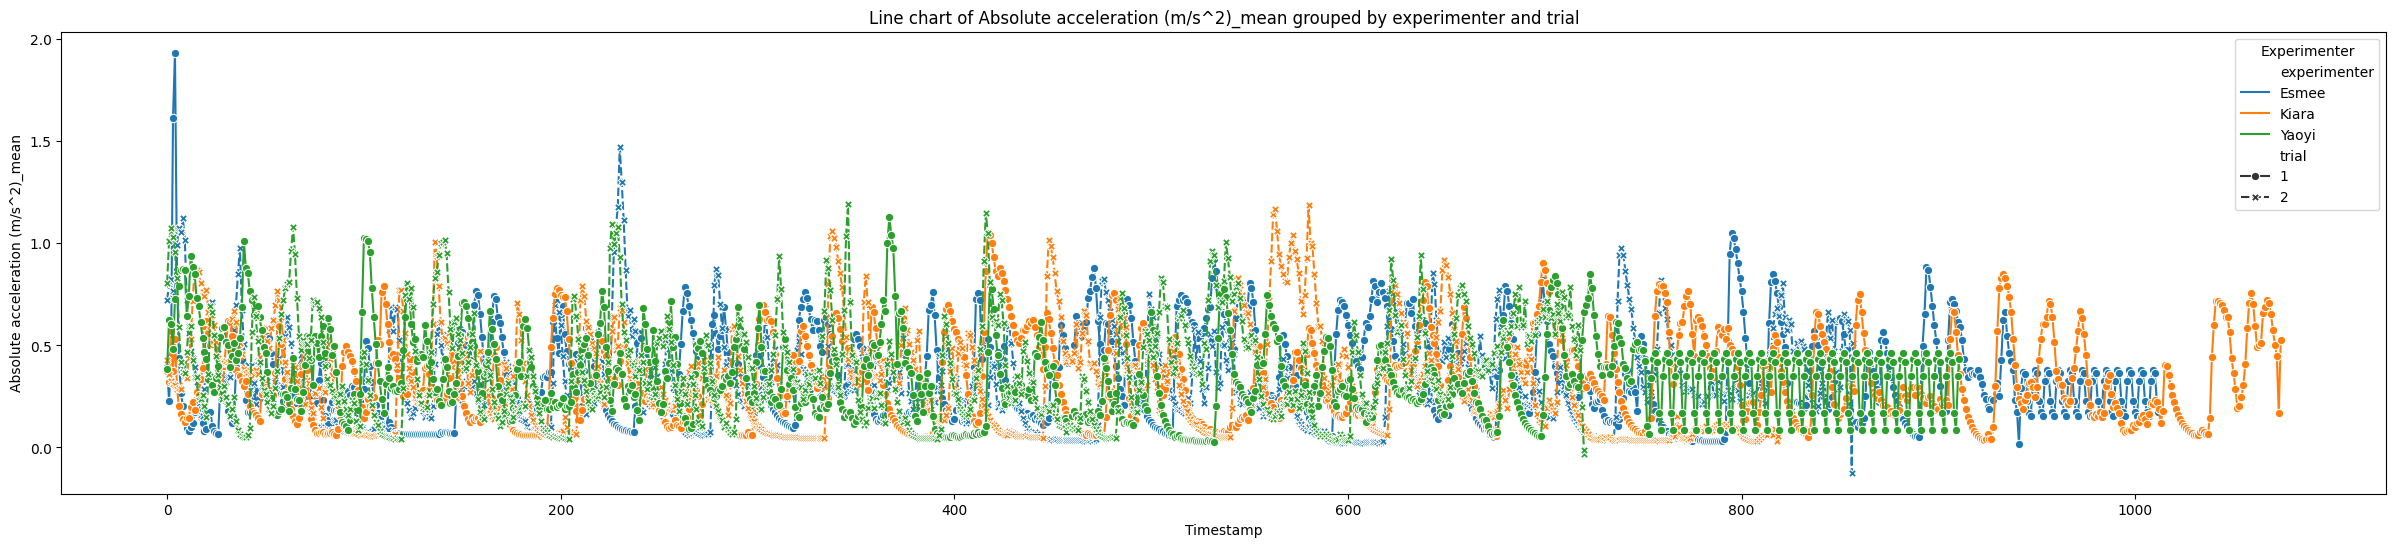

In [91]:
plot_linechart(df, 'Peak-Frequency_mean_lowpass')
plot_linechart(df, 'Absolute acceleration (m/s^2)_mean')

# **Add non-sensor attributes**

In [92]:
def update_seated(df, trial_value, experimenter_value, seated_value):

    if 'seated' not in df.columns:
        df['seated'] = 0

    condition = (df['trial'] == trial_value) & (df['experimenter'] == experimenter_value)
    df.loc[condition, 'seated'] = seated_value

    return df

In [93]:
df = update_seated(df, '1', 'Yaoyi', 0)
df = update_seated(df, '2', 'Yaoyi', 0)
df = update_seated(df, '1', 'Esmee', 1)
df = update_seated(df, '2', 'Esmee', 1)
df = update_seated(df, '1', 'Kiara', 1)
df = update_seated(df, '2', 'Kiara', 1)

In [94]:
df

timestamp trial experimenter  heart_rate  BrightnessEV_max  \
0       0.000000     1        Esmee   80.216627          2.580790   
1       1.000000     1        Esmee   76.748716          2.613659   
2       2.000000     1        Esmee   82.038380          2.646805   
3       3.000000     1        Esmee   86.350644          2.651541   
4       4.000000     1        Esmee   76.489095          2.663653   
...          ...   ...          ...         ...               ...   
5399  718.000000     2        Yaoyi   69.411181          3.351486   
5400  719.000000     2        Yaoyi   67.675253          3.327334   
5401  720.000000     2        Yaoyi   67.675253          3.849135   
5402  720.085676     2        Yaoyi   67.675253          4.005556   
5403         NaN     2        Yaoyi   68.593653          3.556598   

      BrightnessEV_min  BrightnessEV_median  BrightnessEV_mean  \
0             2.550308             2.564395           2.566168   
1             2.561082             2.597676           2.592793   
2             2.603863             2.625844           2.627744   
3             2.627830             2.645232           2.641916   
4             2.635043             2.645683           2.647204   
...                ...                  ...                ...   
5399          3.268921             3.306526           3.310090   
5400          3.244029             3.276745           3.283834   
5401          3.304500             3.616539           3.597495   
5402          3.333631             3.718630           3.690718   
5403          3.342385             3.462920           3.453911   

      BrightnessEV_std  Peak-Frequency_max  ...  \
0             0.008711         1185.020802  ...   
1             0.016046         1495.036197  ...   
2             0.012084         1796.718522  ...   
3             0.008591         1985.080057  ...   
4             0.009520         2088.442653  ...   
...                ...                 ...  ...   
5399          0.029072          115.059237  ...   
5400          0.028233           93.668533  ...   
5401          0.162724           82.503428  ...   
5402          0.207977           76.675684  ...   
5403          0.074646          107.245979  ...   

      Inclination (deg)_median_lowpass  Inclination (deg)_mean_lowpass  \
0                            17.001208                       17.034622   
1                            39.049996                       38.892284   
2                            34.270493                       34.209015   
3                            16.877989                       16.976132   
4                            11.520703                       11.591758   
...                                ...                             ...   
5399                          2.392124                        2.391945   
5400                          2.372948                        2.372987   
5401                          2.333552                        2.333776   
5402                          2.301111                        2.301417   
5403                          2.322163                        2.322122   

      Inclination (deg)_std_lowpass  Rotation (deg)_max_lowpass  \
0                          4.185196                   85.716192   
1                          6.499641                   83.814595   
2                          8.376680                   80.806601   
3                          8.853749                   83.463554   
4                          7.952920                   91.853986   
...                             ...                         ...   
5399                       0.229499                  -10.217870   
5400                       0.281430                  -32.541823   
5401                       0.265461                  -81.345426   
5402                       0.211023                 -112.478913   
5403                       0.171279                 -122.640786   

      Rotation (deg)_min_lowpass  Rotation (deg)_median_lowpass  \
0          

In [95]:
df.columns

Index(['timestamp', 'trial', 'experimenter', 'heart_rate', 'BrightnessEV_max',
       'BrightnessEV_min', 'BrightnessEV_median', 'BrightnessEV_mean',
       'BrightnessEV_std', 'Peak-Frequency_max', 'Peak-Frequency_min',
       'Peak-Frequency_median', 'Peak-Frequency_mean', 'Peak-Frequency_std',
       'Sound pressure level (dB)_max', 'Sound pressure level (dB)_min',
       'Sound pressure level (dB)_median', 'Sound pressure level (dB)_mean',
       'Sound pressure level (dB)_std', 'Linear Acceleration x (m/s^2)_max',
       'Linear Acceleration x (m/s^2)_min',
       'Linear Acceleration x (m/s^2)_median',
       'Linear Acceleration x (m/s^2)_mean',
       'Linear Acceleration x (m/s^2)_std',
       'Linear Acceleration y (m/s^2)_max',
       'Linear Acceleration y (m/s^2)_min',
       'Linear Acceleration y (m/s^2)_median',
       'Linear Acceleration y (m/s^2)_mean',
       'Linear Acceleration y (m/s^2)_std',
       'Linear Acceleration z (m/s^2)_max',
       'Linear Acceleration

In [96]:
lowpass_columns = [i + "_lowpass" for i in columns_to_be_interpolated]
lowpass_columns

['BrightnessEV_max_lowpass',
 'BrightnessEV_min_lowpass',
 'BrightnessEV_median_lowpass',
 'BrightnessEV_mean_lowpass',
 'BrightnessEV_std_lowpass',
 'Peak-Frequency_max_lowpass',
 'Peak-Frequency_min_lowpass',
 'Peak-Frequency_median_lowpass',
 'Peak-Frequency_mean_lowpass',
 'Peak-Frequency_std_lowpass',
 'Sound pressure level (dB)_max_lowpass',
 'Sound pressure level (dB)_min_lowpass',
 'Sound pressure level (dB)_median_lowpass',
 'Sound pressure level (dB)_mean_lowpass',
 'Sound pressure level (dB)_std_lowpass',
 'Linear Acceleration x (m/s^2)_max_lowpass',
 'Linear Acceleration x (m/s^2)_min_lowpass',
 'Linear Acceleration x (m/s^2)_median_lowpass',
 'Linear Acceleration x (m/s^2)_mean_lowpass',
 'Linear Acceleration x (m/s^2)_std_lowpass',
 'Linear Acceleration y (m/s^2)_max_lowpass',
 'Linear Acceleration y (m/s^2)_min_lowpass',
 'Linear Acceleration y (m/s^2)_median_lowpass',
 'Linear Acceleration y (m/s^2)_mean_lowpass',
 'Linear Acceleration y (m/s^2)_std_lowpass',
 'Linear A

# Chapter 4

## Aggregation into 10 s (Numerical)

In [97]:
import numpy as np
import scipy.stats as stats

# Class to abstract a history of numerical values we can use as an attribute.
class NumericalAbstraction:

    # For the slope we need a bit more work.
    # We create time points, assuming discrete time steps with fixed delta t:
    def get_slope(self, data):
        
        times = np.array(range(0, len(data.index)))
        data = data.astype(np.float32)

        # Check for NaN's
        mask = ~np.isnan(data)

        # If we have no data but NaN we return NaN.
        if (len(data[mask]) == 0):
            return np.nan
        # Otherwise we return the slope.
        else:
            slope, _, _, _, _ = stats.linregress(times[mask], data[mask])
            return slope

    #TODO Add your own aggregation function here:
    # def my_aggregation_function(self, data) 

    # This function aggregates a list of values using the specified aggregation
    # function (which can be 'mean', 'max', 'min', 'median', 'std', 'slope')
    def aggregate_value(self,data, window_size, aggregation_function):
        # Reset index to maintain the original format
        data = data.reset_index(drop=True)
        # Compute the values and return the result.
        if aggregation_function == 'mean':
            return data.rolling(window_size, min_periods=1).mean().reset_index(drop=True)
        elif aggregation_function == 'max':
            return data.rolling(window_size, min_periods=1).max().reset_index(drop=True)
        elif aggregation_function == 'min':
            return data.rolling(window_size, min_periods=1).min().reset_index(drop=True)
        elif aggregation_function == 'median':
            return data.rolling(window_size, min_periods=1).median().reset_index(drop=True)
        elif aggregation_function == 'std':
            return data.rolling(window_size, min_periods=1).std().reset_index(drop=True)
        elif aggregation_function == 'slope':
            return data.rolling(window_size, min_periods=1).apply(self.get_slope).reset_index(drop=True)
        
        #TODO: add your own aggregation function here
        else:
            return np.nan


    def abstract_numerical(self, data_table, cols, window_size, aggregation_function_name):
    
        for col in cols:
            # Reset index to maintain the original format
            data_table_reset = data_table.reset_index()
            # Group by 'trial' and 'experimenter' columns before applying aggregation
            grouped = data_table_reset.groupby(['trial', 'experimenter'])[col]
            aggregations = grouped.apply(lambda x: self.aggregate_value(x, window_size, aggregation_function_name))
            data_table[col + '_temp_' + aggregation_function_name + '_ws_' + str(window_size)] = aggregations.values
      
        
        return data_table

In [98]:
numerical_abstraction = NumericalAbstraction()
numerical_abstraction.abstract_numerical(df, lowpass_columns, 10, 'mean')

timestamp trial experimenter  heart_rate  BrightnessEV_max  \
0       0.000000     1        Esmee   80.216627          2.580790   
1       1.000000     1        Esmee   76.748716          2.613659   
2       2.000000     1        Esmee   82.038380          2.646805   
3       3.000000     1        Esmee   86.350644          2.651541   
4       4.000000     1        Esmee   76.489095          2.663653   
...          ...   ...          ...         ...               ...   
5399  718.000000     2        Yaoyi   69.411181          3.351486   
5400  719.000000     2        Yaoyi   67.675253          3.327334   
5401  720.000000     2        Yaoyi   67.675253          3.849135   
5402  720.085676     2        Yaoyi   67.675253          4.005556   
5403         NaN     2        Yaoyi   68.593653          3.556598   

      BrightnessEV_min  BrightnessEV_median  BrightnessEV_mean  \
0             2.550308             2.564395           2.566168   
1             2.561082             2.597676           2.592793   
2             2.603863             2.625844           2.627744   
3             2.627830             2.645232           2.641916   
4             2.635043             2.645683           2.647204   
...                ...                  ...                ...   
5399          3.268921             3.306526           3.310090   
5400          3.244029             3.276745           3.283834   
5401          3.304500             3.616539           3.597495   
5402          3.333631             3.718630           3.690718   
5403          3.342385             3.462920           3.453911   

      BrightnessEV_std  Peak-Frequency_max  ...  \
0             0.008711         1185.020802  ...   
1             0.016046         1495.036197  ...   
2             0.012084         1796.718522  ...   
3             0.008591         1985.080057  ...   
4             0.009520         2088.442653  ...   
...                ...                 ...  ...   
5399          0.029072          115.059237  ...   
5400          0.028233           93.668533  ...   
5401          0.162724           82.503428  ...   
5402          0.207977           76.675684  ...   
5403          0.074646          107.245979  ...   

      Inclination (deg)_min_lowpass_temp_mean_ws_10  \
0                                         15.557868   
1                                         24.921478   
2                                         25.887441   
3                                         22.060112   
4                                         18.872127   
...                                             ...   
5399                                       2.144999   
5400                                       2.245045   
5401                                       2.267448   
5402                                       2.265708   
5403                                       2.262758   

      Inclination (deg)_median_lowpass_temp_mean_ws_10  \
0                                            17.001208   
1                                            28.025602   
2                                            30.107232   
3                                            26.799921   
4                                            23.744078   
...                                                ...   
5399                                          2.291111   
5400                                          2.354447   
5401                                          2.360314   
5402                                          2.357785   
5403                                          2.351871   

      Inclination (deg)_mean_lowpass_temp_mean_ws_10  \
0                                          17.034622   
1                                          27.963453   
2                                          30.045307   
3                                          26.778013   
4                                          23.740762   
...                                              ...   
5399                  

In [99]:
## Fourier Transformation

In [100]:
import numpy as np
import pandas as pd

class FourierTransformation:
    
    def __init__(self):
        self.temp_list = []
        self.freqs = None

    def find_fft_transformation(self, data):
        transformation = np.fft.rfft(data, len(data))
        real_ampl = transformation.real
        max_freq = self.freqs[np.argmax(real_ampl[0:len(real_ampl)])]
        freq_weighted = float(np.sum(self.freqs * real_ampl)) / np.sum(real_ampl)
        PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
        PSD_pdf = np.divide(PSD, np.sum(PSD))
        if np.count_nonzero(PSD_pdf) == PSD_pdf.size:
            pse = -np.sum(np.log(PSD_pdf) * PSD_pdf)
        else:
            pse = 0

        real_ampl = np.insert(real_ampl, 0, max_freq)
        real_ampl = np.insert(real_ampl, 0, freq_weighted)
        row = np.insert(real_ampl, 0, pse)

        self.temp_list.append(row)

        return 0

    def abstract_frequency(self, data_table, columns, window_size, sampling_rate):
        self.freqs = (sampling_rate * np.fft.rfftfreq(int(window_size))).round(3)

        def apply_fft(group):
            for col in columns:
                collist = []
                collist.append(col + '_max_freq')
                collist.append(col + '_freq_weighted')
                collist.append(col + '_pse')
                collist += [col + '_freq_' + str(freq) + '_Hz_ws_' + str(window_size) for freq in self.freqs]
                
                group[col].rolling(window_size + 1).apply(self.find_fft_transformation)

                frequencies = np.pad(np.array(self.temp_list), ((window_size, 0), (0, 0)), 'constant', constant_values=np.nan)
                group[collist] = pd.DataFrame(frequencies, index=group.index)
                del self.temp_list[:]
            
            return group

        data_table = data_table.groupby(['trial', 'experimenter'], as_index=False).apply(apply_fft)
        
        return data_table

In [101]:
mean_columns = [column for column in columns_to_be_interpolated if column.endswith('_mean')]
fouriertransformation = FourierTransformation()
df = fouriertransformation.abstract_frequency(df, mean_columns, 10, 10)

/var/folders/j8/3by2_yfj2tb3sn3c_6m1s3rc0000gn/T/ipykernel_68206/1194438029.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[collist] = pd.DataFrame(frequencies, index=group.index)
/var/folders/j8/3by2_yfj2tb3sn3c_6m1s3rc0000gn/T/ipykernel_68206/1194438029.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  group[collist] = pd.DataFrame(frequencies, index=group.index)
/var/folders/j8/3by2_yfj2tb3sn3c_6m1s3rc0000gn/T/ipykernel_68206/1194438029.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [105]:
nan_count = df.isnull().any(axis=1).sum()
print(nan_count)

61

In [106]:
df = df.dropna()

In [107]:
df.to_csv('./data/aggregate_data.csv', index=False)